# HOTEL BOOKING PREDICTION

# Required libraries

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
plt.rcParams['figure.figsize'] = [15, 6]
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score,roc_curve,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,StackingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

In [33]:
# reading the dataset

In [34]:
df = pd.read_csv('hotel_bookings.csv')

In [35]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [36]:
df.shape

(119390, 32)

In [37]:
# there are 119390 rows and 32 columns in this dataset

In [38]:
df.info() # checking the data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Pre processing

In [39]:
# changing the columns to object datatype as they are categorical variables

In [40]:
df['agent'] = df['agent'].astype('object')

In [41]:
df[['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month']] = df[['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month']].astype(object)

In [42]:
df[['is_canceled','is_repeated_guest']] = df[['is_canceled','is_repeated_guest']].astype(object)

In [43]:
# dropping the redundant column reservation status as it provides the same meaning as is cancelled

In [44]:
df = df.drop('reservation_status',axis=1)

# Missing value analysis

In [45]:
# checking for null values
# missing value analysis

In [46]:
df.isnull().sum()/len(df)*100

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

In [47]:
# as there are more than 90 percent missing values in the column agent, we are dropping the column

In [48]:
df = df.drop('company',axis=1)

In [49]:
# as the column country a categorical variable we are using mode to impute the null values

In [50]:
df["country"]=df["country"].fillna(df["country"].mode()[0])

In [51]:
# filling in the column children

In [52]:
df.loc[df['children'].isnull(),'children'] = 0

In [53]:
# filling in the column agent with mode as it is of object data type

In [54]:
df['agent'].mode()

0    9.0
Name: agent, dtype: object

In [55]:
df.loc[df['agent'].isnull(),'agent'] = 9.0

In [56]:
df['stays_in_weekend_nights'].value_counts()

0     51998
2     33308
1     30626
4      1855
3      1259
6       153
5        79
8        60
7        19
9        11
10        7
12        5
13        3
16        3
14        2
18        1
19        1
Name: stays_in_weekend_nights, dtype: int64

# EDA

# Seperating the numerical and categorical columns

In [57]:
numerical = df.select_dtypes(include=np.number)

In [58]:
categorical = df.select_dtypes(exclude=np.number)

In [59]:
numerical.describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,104.011416,0.927599,2.500302,1.856403,0.103886,0.007949,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,106.863097,0.998613,1.908286,0.579261,0.398555,0.097436,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,69.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,160.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [60]:
categorical.describe()

,hotel,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,agent,customer_type,reservation_status_date
count,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390.0,119390,119390
unique,2,2,3,12,53,31,5,177,8,5,2,10,12,3,333.0,4,926
top,City Hotel,0,2016,August,33,17,BB,PRT,Online TA,TA/TO,0,A,A,No Deposit,9.0,Transient,2015-10-21
freq,79330,75166,56707,13877,3580,4406,92310,49078,56477,97870,115580,85994,74053,104641,48301.0,89613,1461


# Heatmap to provide us with the insights about correlations among the numerical variables

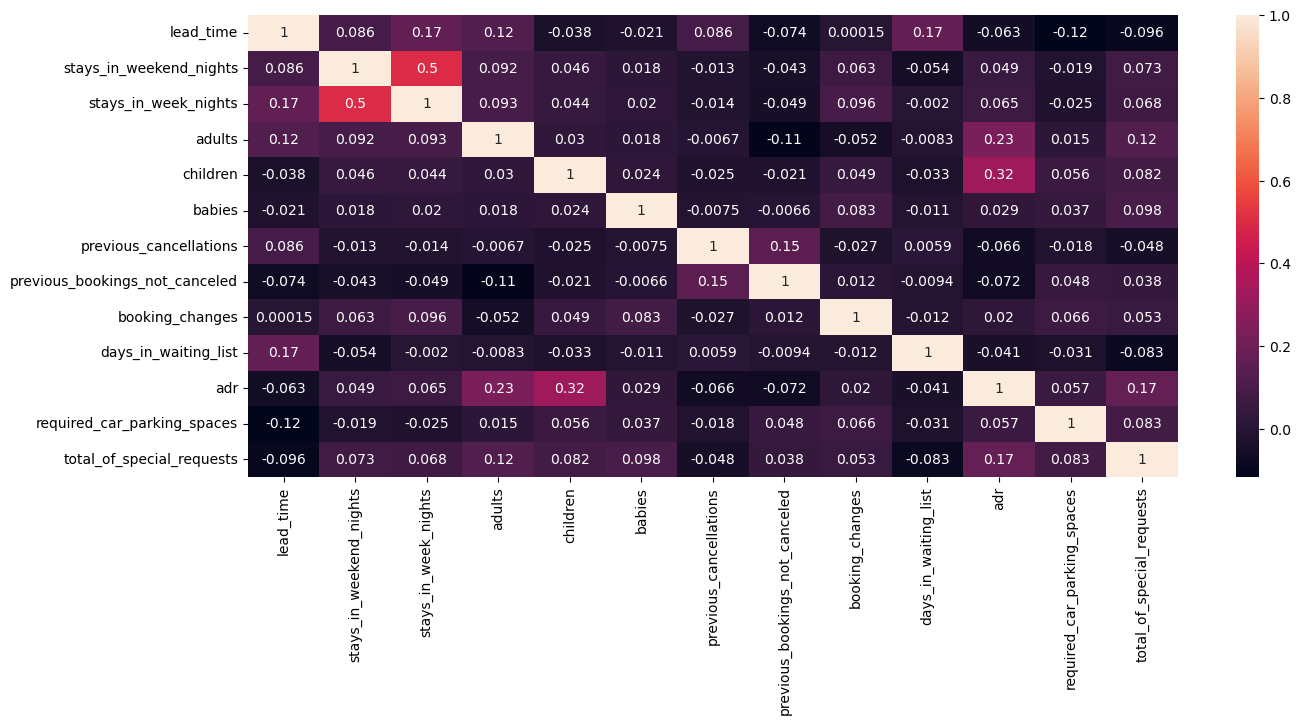

In [61]:
cmap = "tab20"
  
# plotting the heatmap
hm = sns.heatmap(numerical.corr(),
                annot=True)
  
# displaying the plotted heatmap
plt.show()

We can observe that there is no significant multicollinearity among the variables, which is a positive aspect to consider during our model building process
and there is moderate correlation between the independant variables and Target variable

# Target variable analysis - Number of cancellations

In [62]:
canceled = len(df[df['is_canceled'] == 1])

In [63]:
not_canceled = len(df[df['is_canceled'] == 0])

In [64]:
print((df['is_canceled'].value_counts()))

0    75166
1    44224
Name: is_canceled, dtype: int64


In [66]:
print((df['is_canceled'].value_counts(normalize=True)*100))

0    62.958372
1    37.041628
Name: is_canceled, dtype: float64


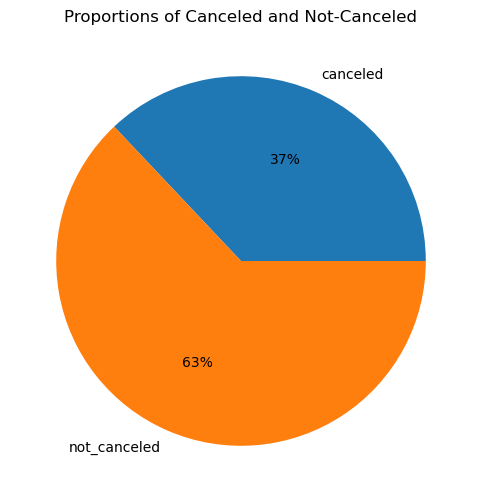

In [68]:
palette_color = sns.color_palette('bright')
plt.pie([canceled,not_canceled],labels=['canceled','not_canceled'], autopct='%.0f%%')
plt.title('Proportions of Canceled and Not-Canceled')
# displaying chart
plt.show()

From the above pie chart we can see that the percentage of people who have not cancelled are considerably higher than the people who have cancelled the booking 

<Axes: xlabel='is_canceled', ylabel='count'>

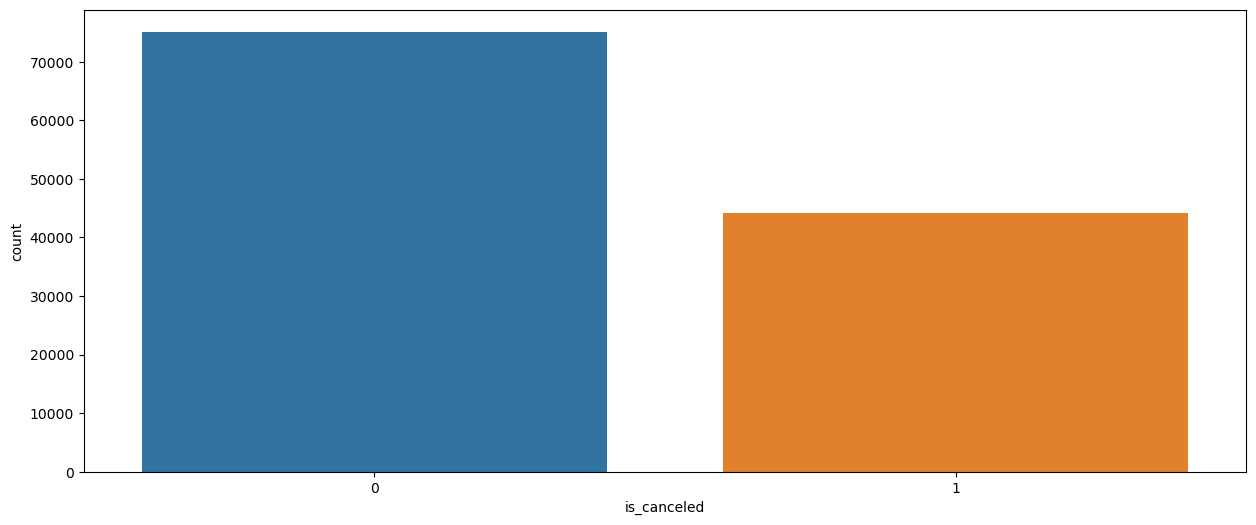

In [40]:
sns.countplot(x=df['is_canceled'])

There are 44224 cancellations which accounts for 37 percent of the total cancellations

# Univariate

In [41]:
df.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,9.0,0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,9.0,0,Transient,0.0,0,0,2015-07-01


# Column - 'hotel' 

In [42]:
df['hotel'].value_counts(normalize = True)*100

City Hotel      66.446101
Resort Hotel    33.553899
Name: hotel, dtype: float64

<Axes: xlabel='hotel', ylabel='count'>

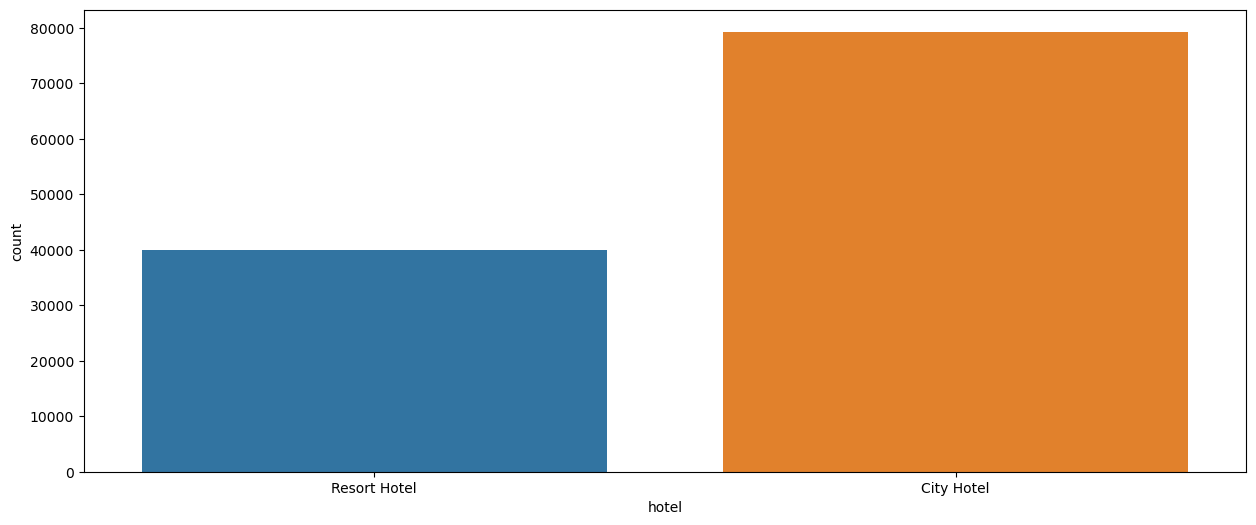

In [43]:
sns.countplot(x=df['hotel'])

In [44]:
# inference 

# we can see that the variable 'hotel has two subclasses 
# 66% of the hotels are 'city hotel'
# 33% of the hotels are 'resort hotel'
# with the data we can see that there are double the amount of bookings in 'city hotel' than 'resort hotel'

# Column - 'lead_time' 

<Axes: ylabel='Density'>

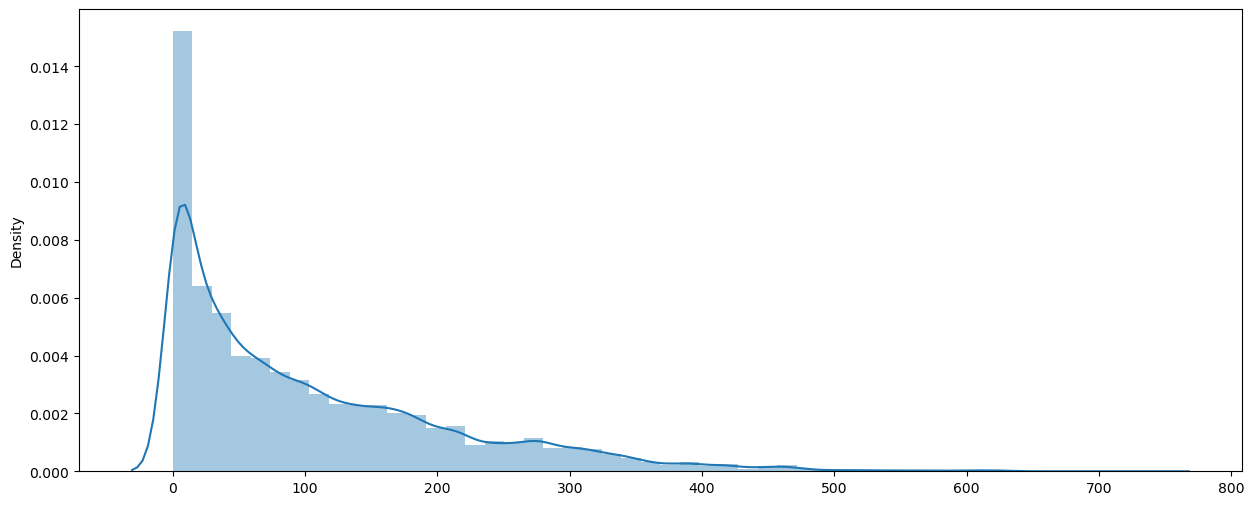

In [45]:
sns.distplot(x=df['lead_time'])

In [46]:
df['lead_time'].skew()

1.3465498727254268

In [47]:
# inference 

# Number of days that elapsed between the entering date of the booking into the system and the arrival date
# from the above graph we can see that most of the people arrive immediately after date of booking 
# people who book in advance are less 
# the data is highly right skewed 

# Column - 'arrival_date_year' 

In [48]:
df['arrival_date_year'].value_counts(normalize=True)*100

2016    47.497278
2017    34.079069
2015    18.423654
Name: arrival_date_year, dtype: float64

<Axes: xlabel='arrival_date_year', ylabel='count'>

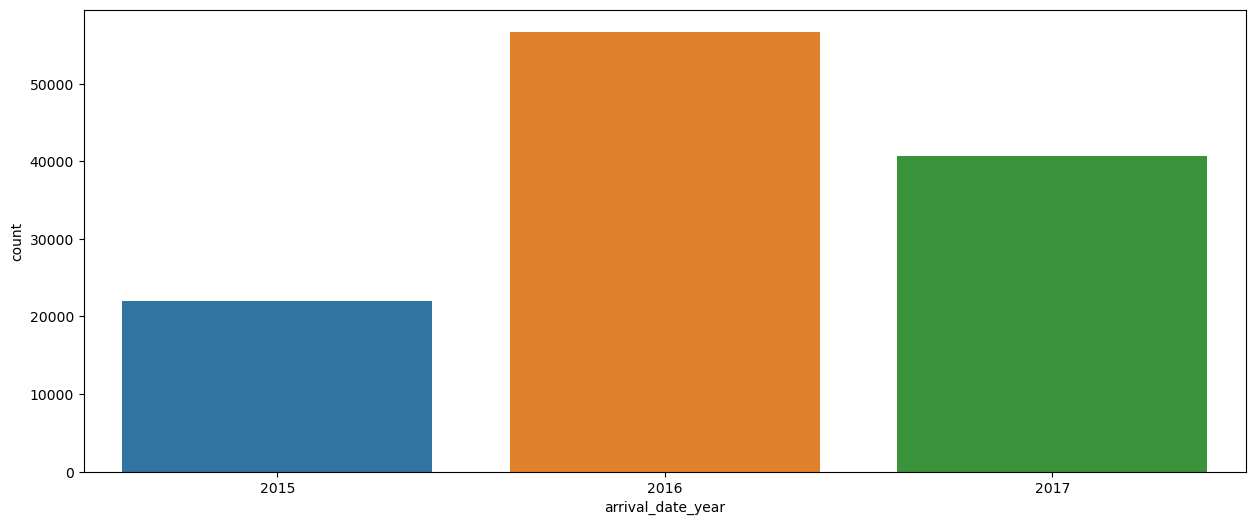

In [49]:
sns.countplot(x=df['arrival_date_year'])

In [50]:
# inference 
# we can see from the data that
# 34.0% of the data is from 2017
# 47.4% of the data is from 2016
# 18.4% of the data is from 2015
# it is observed that more people have visited hotels in the year 2016

# Column - 'arrival_date_month' 

In [51]:
df['arrival_date_month'].value_counts(normalize=True)*100

August       11.623252
July         10.604741
May           9.876037
October       9.347517
April         9.288048
June          9.162409
September     8.801407
March         8.203367
February      6.757685
November      5.690594
December      5.678868
January       4.966078
Name: arrival_date_month, dtype: float64

In [52]:
# inference 

# we can see that the hotel bookings are high in July and Augest 
# this hike in hotel bookings can be due to many reasons 
# Summer Vacation Season:
# In many countries, July and August coincide with the summer vacation season when schools are out, and families and individuals take extended breaks. This leads to increased travel and, consequently, higher hotel bookings.
# Good Weather:
# July and August are typically associated with warm weather and longer daylight hours in many parts of the world. This pleasant weather encourages people to travel, go on outdoor adventures, and visit tourist destinations.
# International Tourism:
# July and August are prime months for international travel, with tourists from around the world exploring different countries and regions. This influx of international travelers contributes to higher hotel occupancy rates.

# Column - 'stays_in_weekend_nights' 

In [53]:
df['stays_in_weekend_nights'].value_counts(normalize=True)*100

0     43.553061
2     27.898484
1     25.652065
4      1.553731
3      1.054527
6      0.128151
5      0.066170
8      0.050255
7      0.015914
9      0.009214
10     0.005863
12     0.004188
13     0.002513
16     0.002513
14     0.001675
18     0.000838
19     0.000838
Name: stays_in_weekend_nights, dtype: float64

<Axes: xlabel='stays_in_weekend_nights', ylabel='count'>

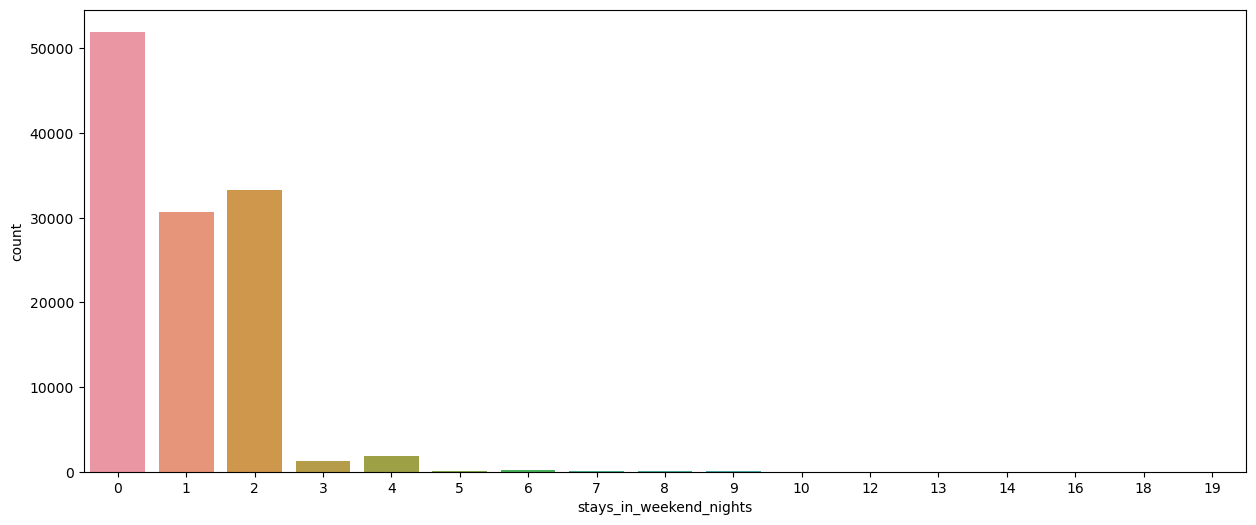

In [54]:
sns.countplot(x=df['stays_in_weekend_nights'])

In [55]:
# inference 

# Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
# we can see that most customers prefer to stay in the weekend nights mostly once or twice 
# 43.5% of the people do not prefer to stay in weekend nights 
# 25.7% of the people stay once in the weekend nights 
# 27.8% of the people stay twice in the weekend nights 
# Leisure and Getaways:
# Weekends offer a break from the routine of work and daily responsibilities, making them an ideal time for leisure travel. People take advantage of weekends to go on getaways, explore new places, and relax.
# Extended Vacations:
# Many travelers plan longer vacations that include weekends to maximize their time away from work. They may book hotel stays to cover both weekdays and weekends during these trips.

# Column - 'stays_in_week_nights' 

<Axes: xlabel='stays_in_week_nights', ylabel='count'>

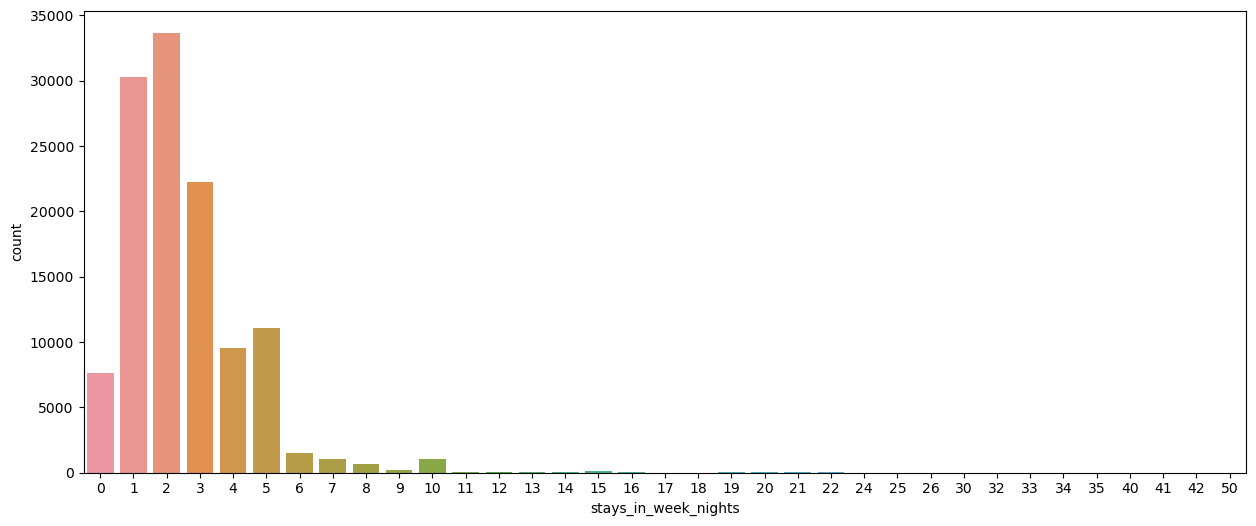

In [56]:
sns.countplot(x=df['stays_in_week_nights'])

In [57]:
# inference 

# Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
# from the data we can see that maximum people who who stay in week nights usually stay from one to three days 
# we can also observe that the data is highly skewed 
# Business Travel:
# Weeknight hotel stays are often driven by business travel. Professionals travel for work-related meetings, conferences, and training sessions during the workweek and may stay in hotels for convenience and proximity to their work commitments.

# Column - 'adults' 

In [58]:
df['adults'].value_counts(normalize=True)*100

2     75.115169
1     19.287210
3      5.194740
0      0.337549
4      0.051931
26     0.004188
27     0.001675
20     0.001675
5      0.001675
40     0.000838
50     0.000838
55     0.000838
6      0.000838
10     0.000838
Name: adults, dtype: float64

<Axes: xlabel='adults', ylabel='count'>

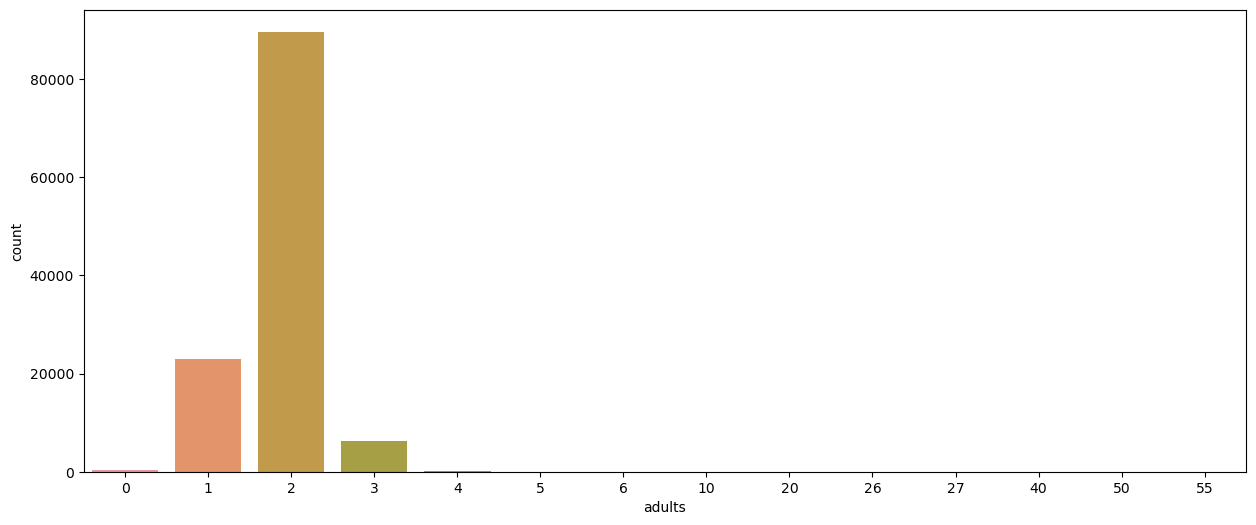

In [59]:
sns.countplot(x=df['adults'])

In [60]:
# inference 
# this column is for the count of adults 
# 75% of the customers come in twos 
# 19% of the customers come once

# To find the country where maximum no of bookings occured

In [61]:
((df['country'].value_counts(normalize=True)*100).head())

PRT    41.107295
GBR    10.159142
FRA     8.723511
ESP     7.176480
DEU     6.103526
Name: country, dtype: float64

<Axes: >

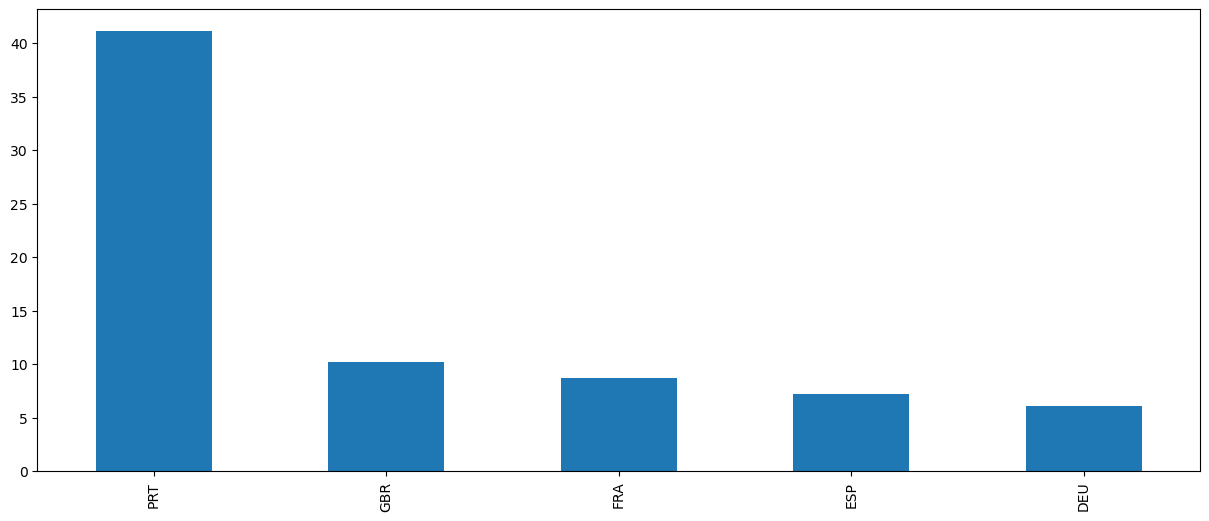

In [62]:
((df['country'].value_counts(normalize=True)*100).head()).plot(kind='bar',)

we can see that the maximum number of bookings occured from Portugal which accounts for around 41 percentage, followed by Great Britain and France

# Market segment

<Axes: ylabel='market_segment'>

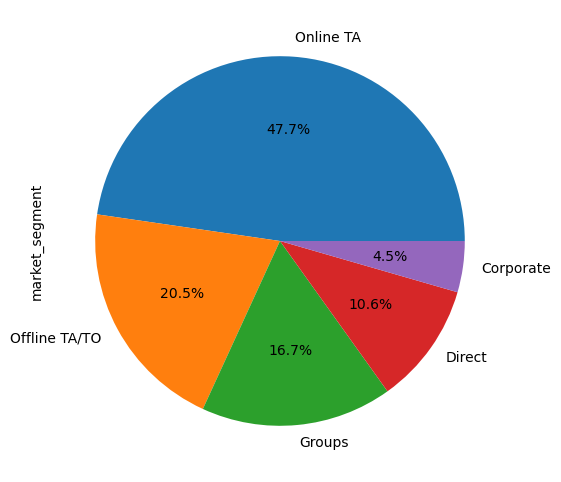

In [63]:
((df['market_segment'].value_counts(normalize=True)*100).head()).plot(kind='pie',autopct='%0.1f%%')

The maximum number of booking was done by the online travel agency which accounts for 47,7 percent of the total followed by offline travel agency with a contribution of 20.5 percent.

# Bivariate Analysis

<Axes: xlabel='hotel', ylabel='lead_time'>

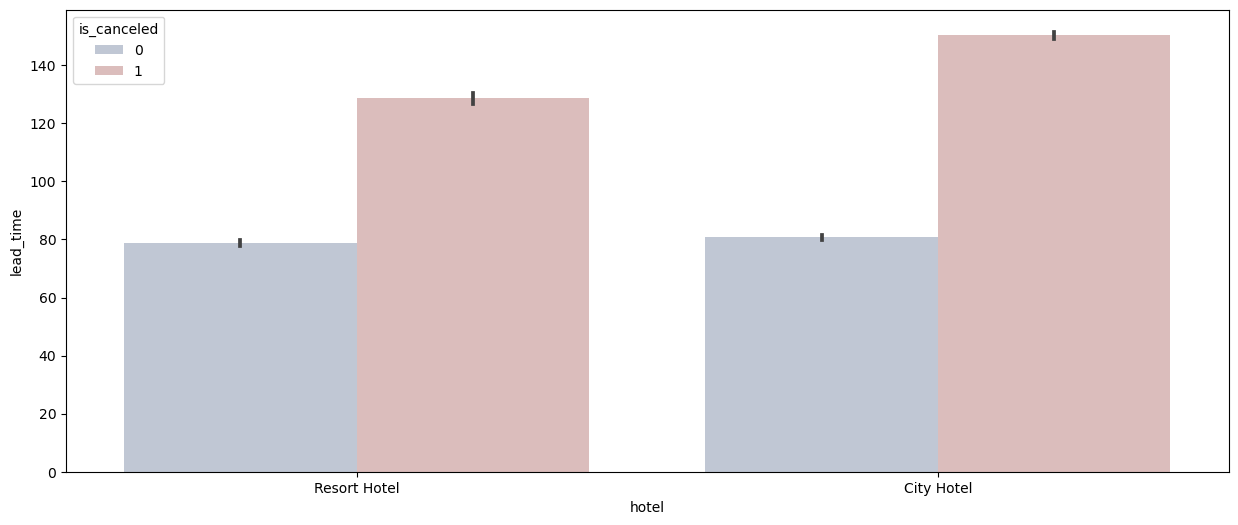

In [64]:
sns.barplot(x=df['hotel'],y=df['lead_time'],hue=df['is_canceled'],palette = 'vlag')

In both the hotels the bookings with more than a lead time of 80 days have higher chances of cancellations

<Axes: xlabel='is_canceled', ylabel='count'>

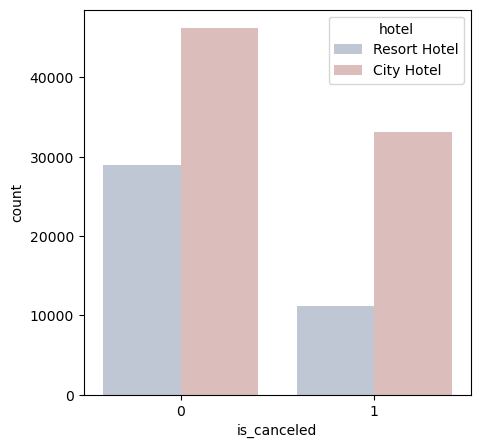

In [65]:
plt.figure(figsize=(5,5))
sns.countplot(x = df['is_canceled'],palette='vlag',hue=df['hotel'])

In [66]:
df[df['is_canceled'] == 1]['hotel'].value_counts(normalize='True')*100

City Hotel      74.85076
Resort Hotel    25.14924
Name: hotel, dtype: float64

In the cancelled bookings we can see that more number of cancellations occured at City hotel which accounts for around 74 percentage

In [67]:
df[df['is_canceled'] == 1]['customer_type'].value_counts(normalize='True')*100

Transient          82.566027
Transient-Party    14.446907
Contract            2.853654
Group               0.133412
Name: customer_type, dtype: float64

<Axes: xlabel='customer_type', ylabel='count'>

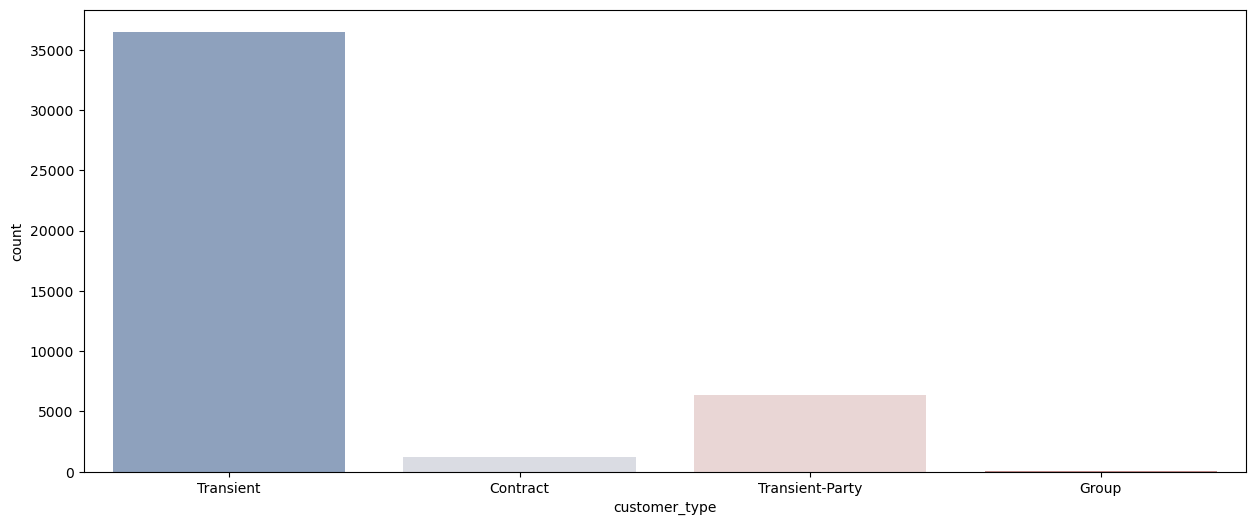

In [68]:
cancelled = df[df['is_canceled']==1]
sns.countplot(x=cancelled['customer_type'],palette='vlag')

The ones with customer_type as transient are the ones with a short stay who have no special requirements, notably the cancellations are higher for the transient customer_types which is around 82 percent.

# Assumption-1

The earlier the booking made, higher the chances of cancellation.
if the person has a higher lead time ie the duration between the day they booked and the date of arrival, he/she has a higher possibility of cancellation

<Axes: xlabel='lead_time', ylabel='Count'>

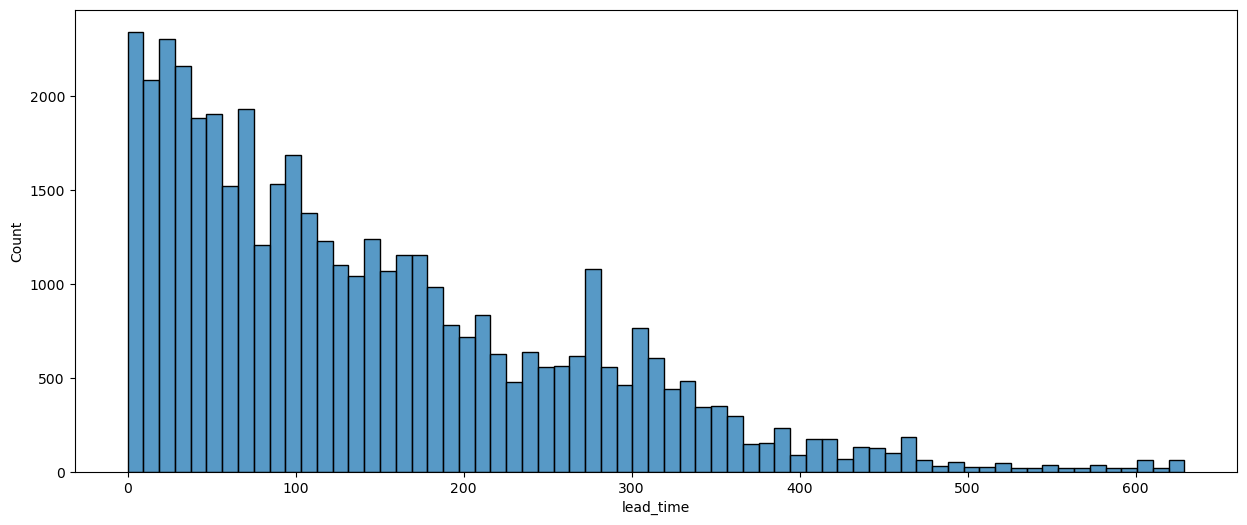

In [69]:
sns.histplot(cancelled['lead_time'])

## Inference
Higher the lead time lesser the cancellation, this disapproves our assumption 1

In [70]:
# hypothesis testing 
# H0 - null hypothesis - lower lead time, higher the possibility of cancellaltion
# H1 - alternate hypotesis - higher lead, higher the possibility of cancellation
# right tailed test

In [71]:
higher_lead_time = cancelled[cancelled['lead_time'] > 300]['lead_time'] 

In [72]:
lower_lead_time = cancelled[cancelled['lead_time'] < 300]['lead_time'] 

In [73]:
stats.ttest_ind(a=higher_lead_time,b=lower_lead_time,alternative='less')

Ttest_indResult(statistic=222.64716727968892, pvalue=1.0)

Failed to reject null hypothesis states that the null hypothesis might be true

indicating that lower the lead time higher the possibility of cancellation
which can be observed from the graph as well

# Assumption - 2

If there are high previous cancellations, possibility of cancellation of current booking is also high.

In [74]:
previously_cancelled = df[df['previous_cancellations'] >= 1]

<Axes: xlabel='previous_cancellations', ylabel='count'>

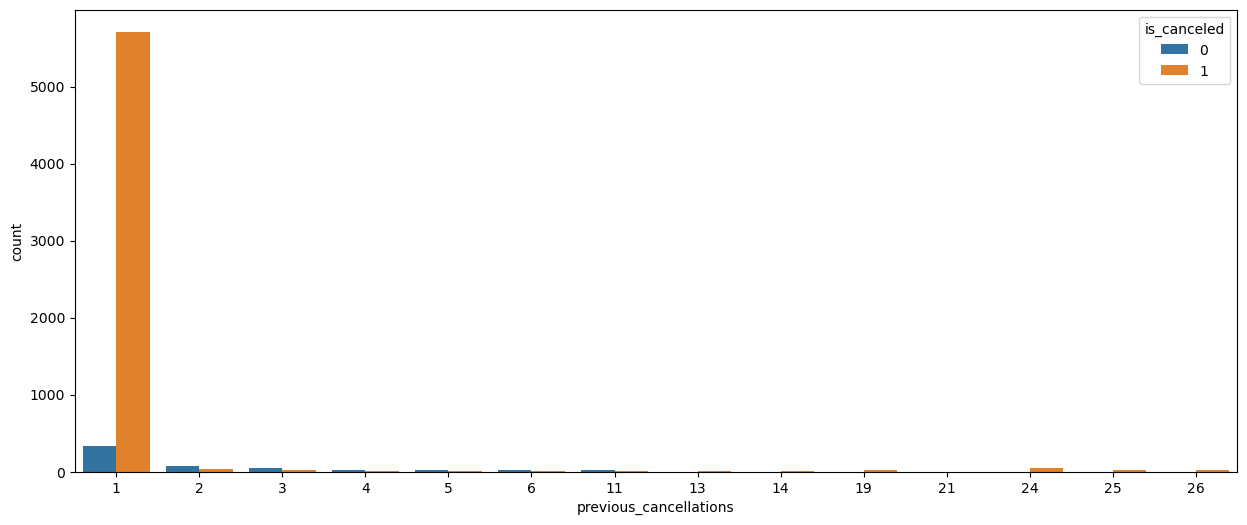

In [75]:
sns.countplot(x=previously_cancelled['previous_cancellations'],hue=previously_cancelled['is_canceled'])

## Inference

The customers who have booked earlier and the customers who have previously cancelled have a high chance to cancel their booking

In [76]:
# hypothesis
# H0 - null hypothesis
# The cancellation status of the current booking is independant of the previous cancellation.
# H1 - alternate hypothesis
# The cancellation status of the current booking is dependant of the previous cancellation.

In [77]:
cancelled = previously_cancelled[previously_cancelled['is_canceled'] == 1]['previous_cancellations']
not_cancelled = previously_cancelled[previously_cancelled['is_canceled'] == 0]['previous_cancellations']

In [78]:
stats.ttest_ind(a=not_cancelled,b=cancelled,alternative='greater')

Ttest_indResult(statistic=4.363347991353643, pvalue=6.503687652056302e-06)

Rejecting null hypothesis, states that the current booking is dependant on the previous cancellation

# Assumption - 3

If room assigned is not the same as reserved room type, customer might positively cancel the booking (ie) the customer does not get the same room as the mentioned during the time of booking, the chances of that customer cancelling the booking is high

In [79]:
temp = df.loc[df['reserved_room_type']!=df['assigned_room_type']]
temp['is_canceled'].value_counts(normalize=True)*100

0    94.623584
1     5.376416
Name: is_canceled, dtype: float64

## Inference 

when the room type mentioned by the customer is not provided by the hotel, the people who have cancelled accounts for only 5 percent, thus it dissaproves our assumption

# Assumption - 4

Higher the number of changes made to the booking, lesser is the chance of cancellation due to the investment of time in curating the booking as per one's requirement.

<Axes: xlabel='booking_changes', ylabel='count'>

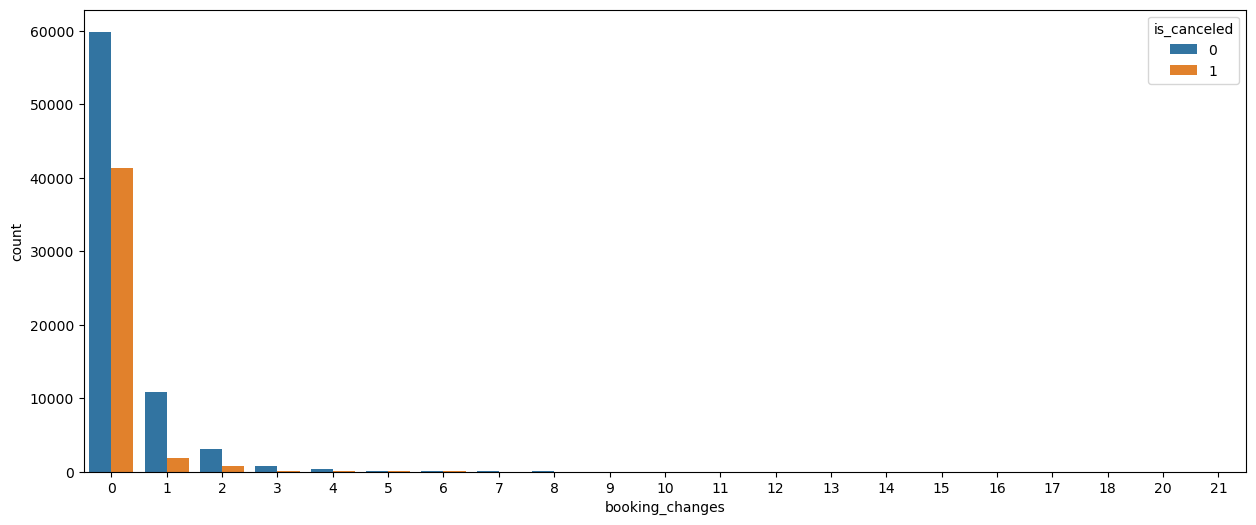

In [80]:
sns.countplot(data=df, x='booking_changes', hue='is_canceled')

## Inference

The bookings does not hold as there is no trend in it's impact on the cancellation of bookings.

In [81]:
# Hypothesis
# null - the booking changes does not have an impact on the cancellation
# alternate - the number of booking changes has an impact on the number of cancellations

In [82]:
changes = df[df['booking_changes'] > 1]

In [83]:
not_cancelled = changes[changes['is_canceled'] == 0]['booking_changes']
cancelled = changes[changes['is_canceled'] == 1]['booking_changes']

In [84]:
stats.ttest_ind(a=not_cancelled,b=cancelled,alternative='less')

Ttest_indResult(statistic=1.9535777521477449, pvalue=0.9745985018985022)

Failed to reject null hypothesis, the number of booking changes does not have an impact on the cancellation

# Asumption - 5

Bookings that are refundable or for which deposits were not made at the time of booking stand a high chance of cancelation.

<Axes: xlabel='deposit_type', ylabel='count'>

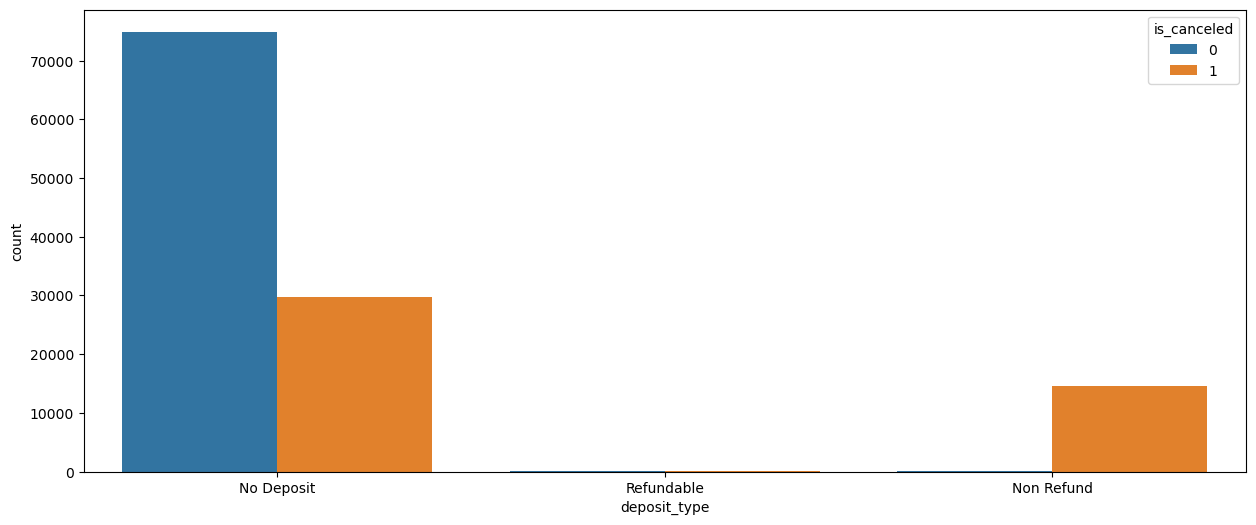

In [85]:
sns.countplot(x="deposit_type", hue="is_canceled",data=df)

## Inference
Most of the people with non refundable deposit type have cancelled

# Assumption - 6

Maximum booking occured in a year

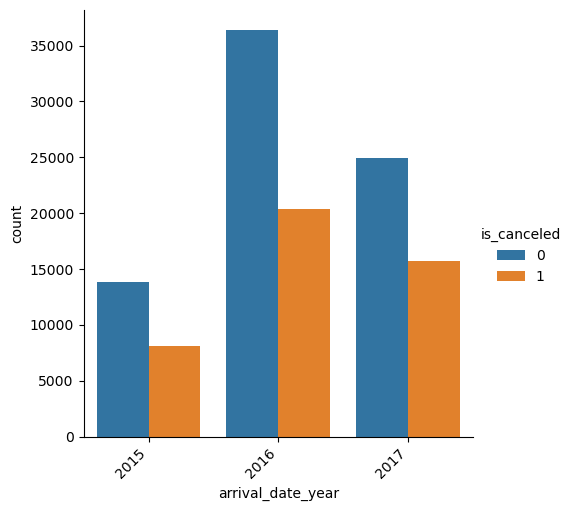

In [86]:
chart = sns.catplot(data=df, x='arrival_date_year', hue='is_canceled', kind='count')
chart.set_xticklabels(rotation=45, horizontalalignment='right')

## Inference 

From the above graph we could infer that the maximum number of bookings has ocured in the Year 2016

# Assumption - 7

Type of hotels that have longer waiting period

<Figure size 2900x600 with 0 Axes>

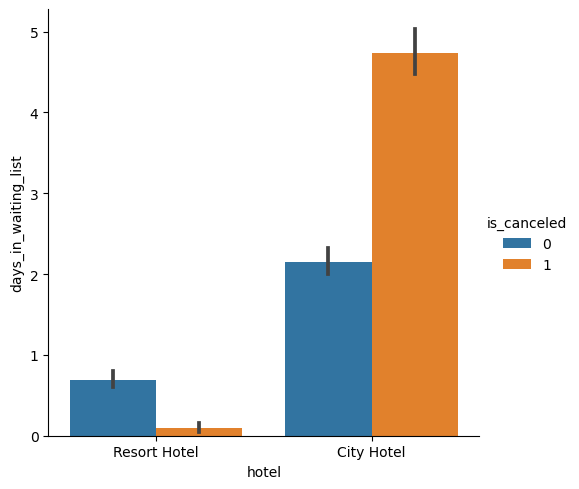

In [87]:
fig=plt.figure(figsize=(29,6))
sns.catplot(data=df, x='hotel', y='days_in_waiting_list',hue='is_canceled',kind='bar')

## Inference

city hotels have much longer waiting time in days compared to resort hotels which may signify that their demad is higher.

In [88]:
city_hotel = df[df['hotel'] == 'City Hotel']['days_in_waiting_list']
Resort_hotel = df[df['hotel'] == 'Resort Hotel']['days_in_waiting_list']

In [89]:
# Hypothesis testing
# H0 - City hotel and resort hotel have the same waiting time.
# H1 - city hotel and resort hotel have different waiting time.

In [90]:
stats.ttest_ind(a=city_hotel,b=Resort_hotel)

Ttest_indResult(statistic=25.093064562539695, pvalue=1.357677857696026e-138)

reject null hypothesis, therefore the city and resort hotel have different waiting times

# Assumption - 8

Type of customers that cancelled most

Transient          75.059050
Transient-Party    21.043638
Contract            3.414021
Group               0.483290
Name: customer_type, dtype: float64


<Axes: xlabel='customer_type', ylabel='count'>

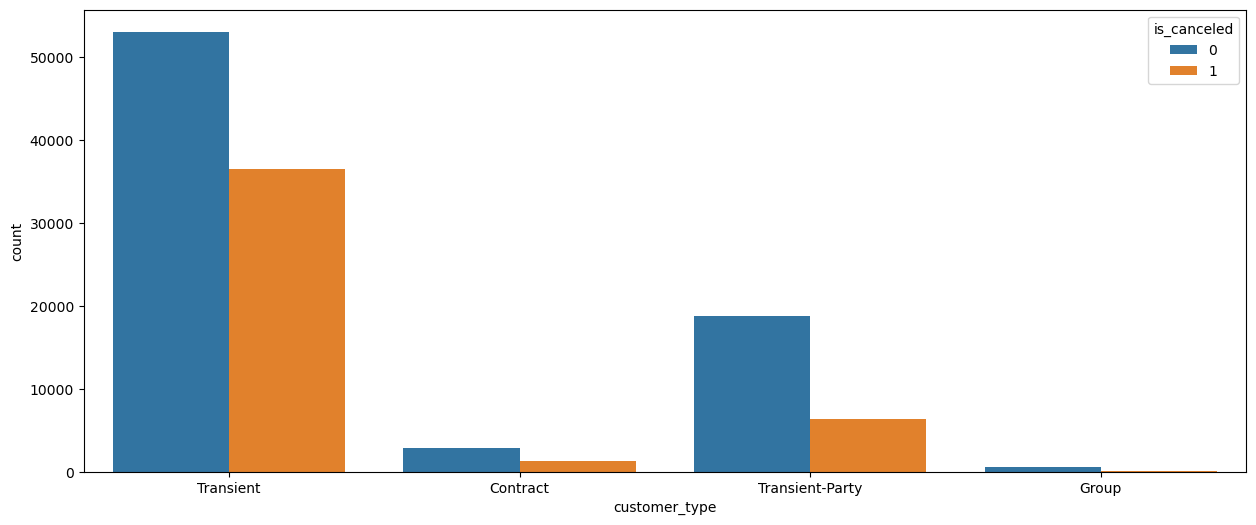

In [91]:
print(df['customer_type'].value_counts(normalize=True)*100)
sns.countplot(data=df, x='customer_type', hue='is_canceled')

## Inference 

75% bookings occur in Transient category of customers. It also sees the highest cancellation among all the categories

# Assumption - 9

Month in every year with most cancelations

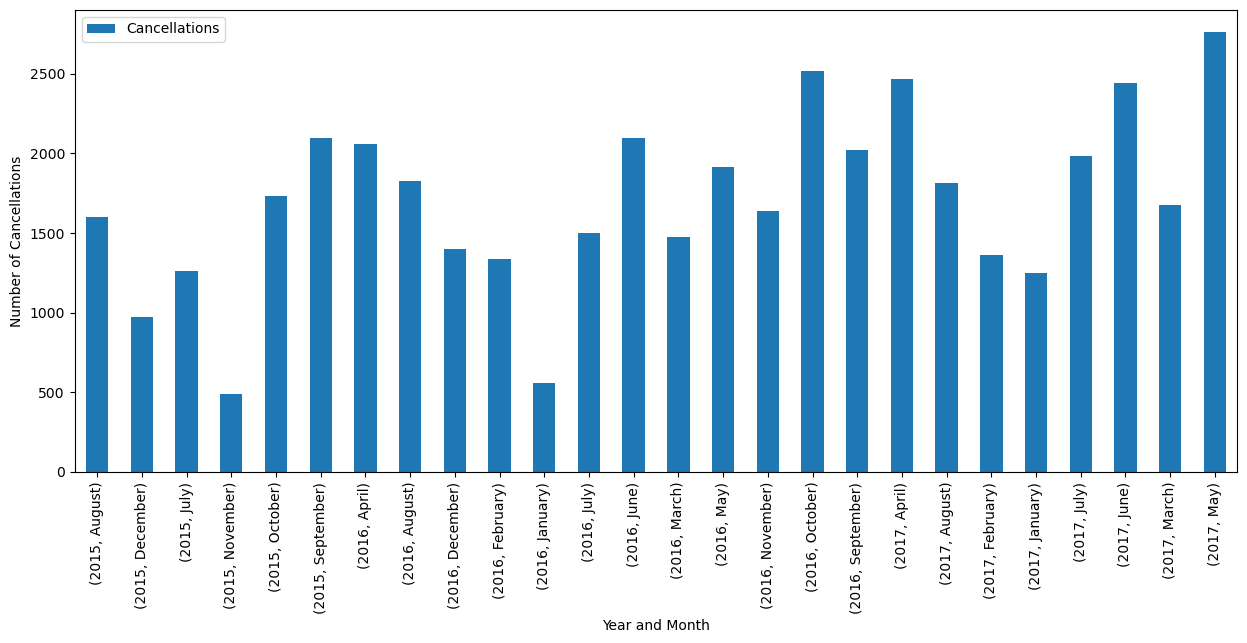

In [92]:
cancelled = df[df['is_canceled']==1]

cancelled.groupby(['arrival_date_year','arrival_date_month'])['is_canceled'].count().plot(kind='bar')

plt.xlabel('Year and Month')
plt.ylabel('Number of Cancellations')
plt.legend(['Cancellations'], loc='upper left')
plt.show()

## Inference

1. For the year 2015 it is observed that the maximum number of cancellations occured in the month of september.
2. For the year 2016 it is observed that the maximum number of cancellations occured in the month of October.
3. For the year 2017 it is observed that the maximum number of cancellations occured in the month of May.

# Outlier detection

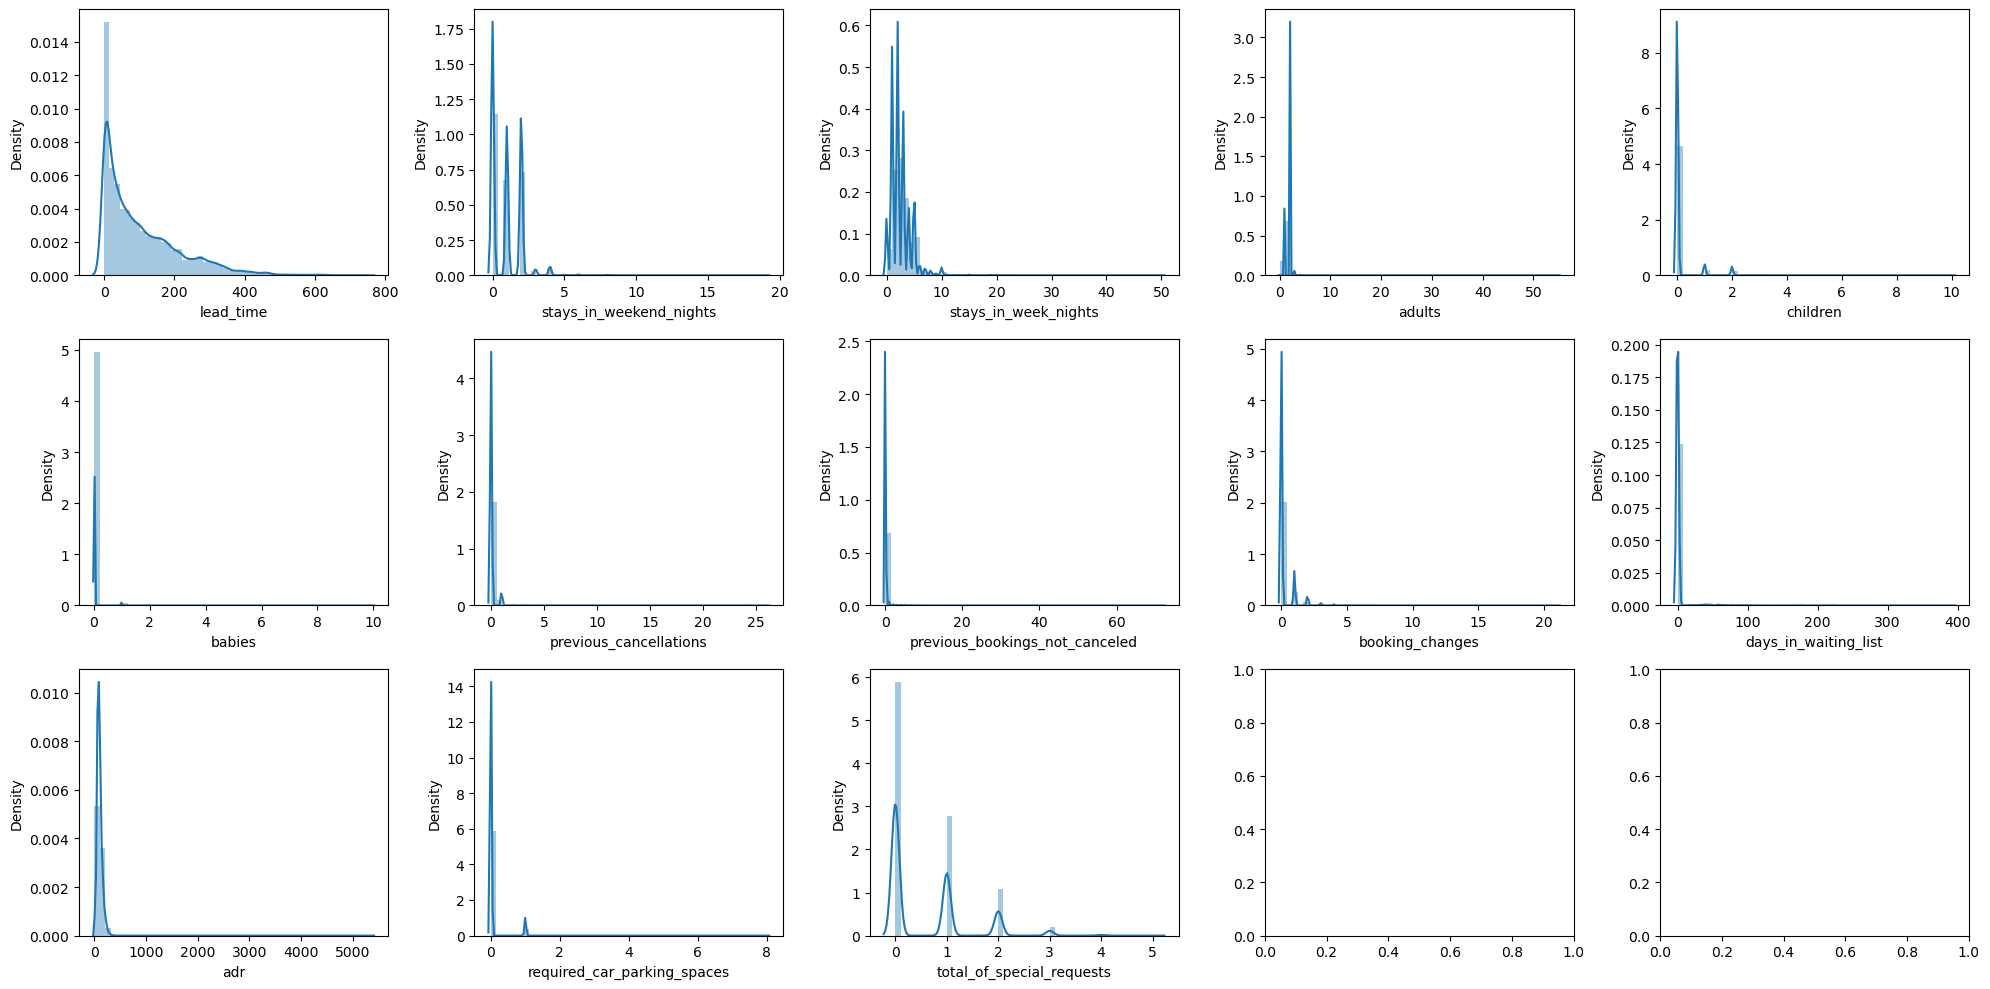

In [93]:
fig, ax= plt.subplots(3,5, figsize=(20,10))

for i, subplot in zip(numerical.columns, ax.flatten()):
    sns.distplot(df[i], ax=subplot,kde=True)
    
plt.tight_layout()
plt.show()

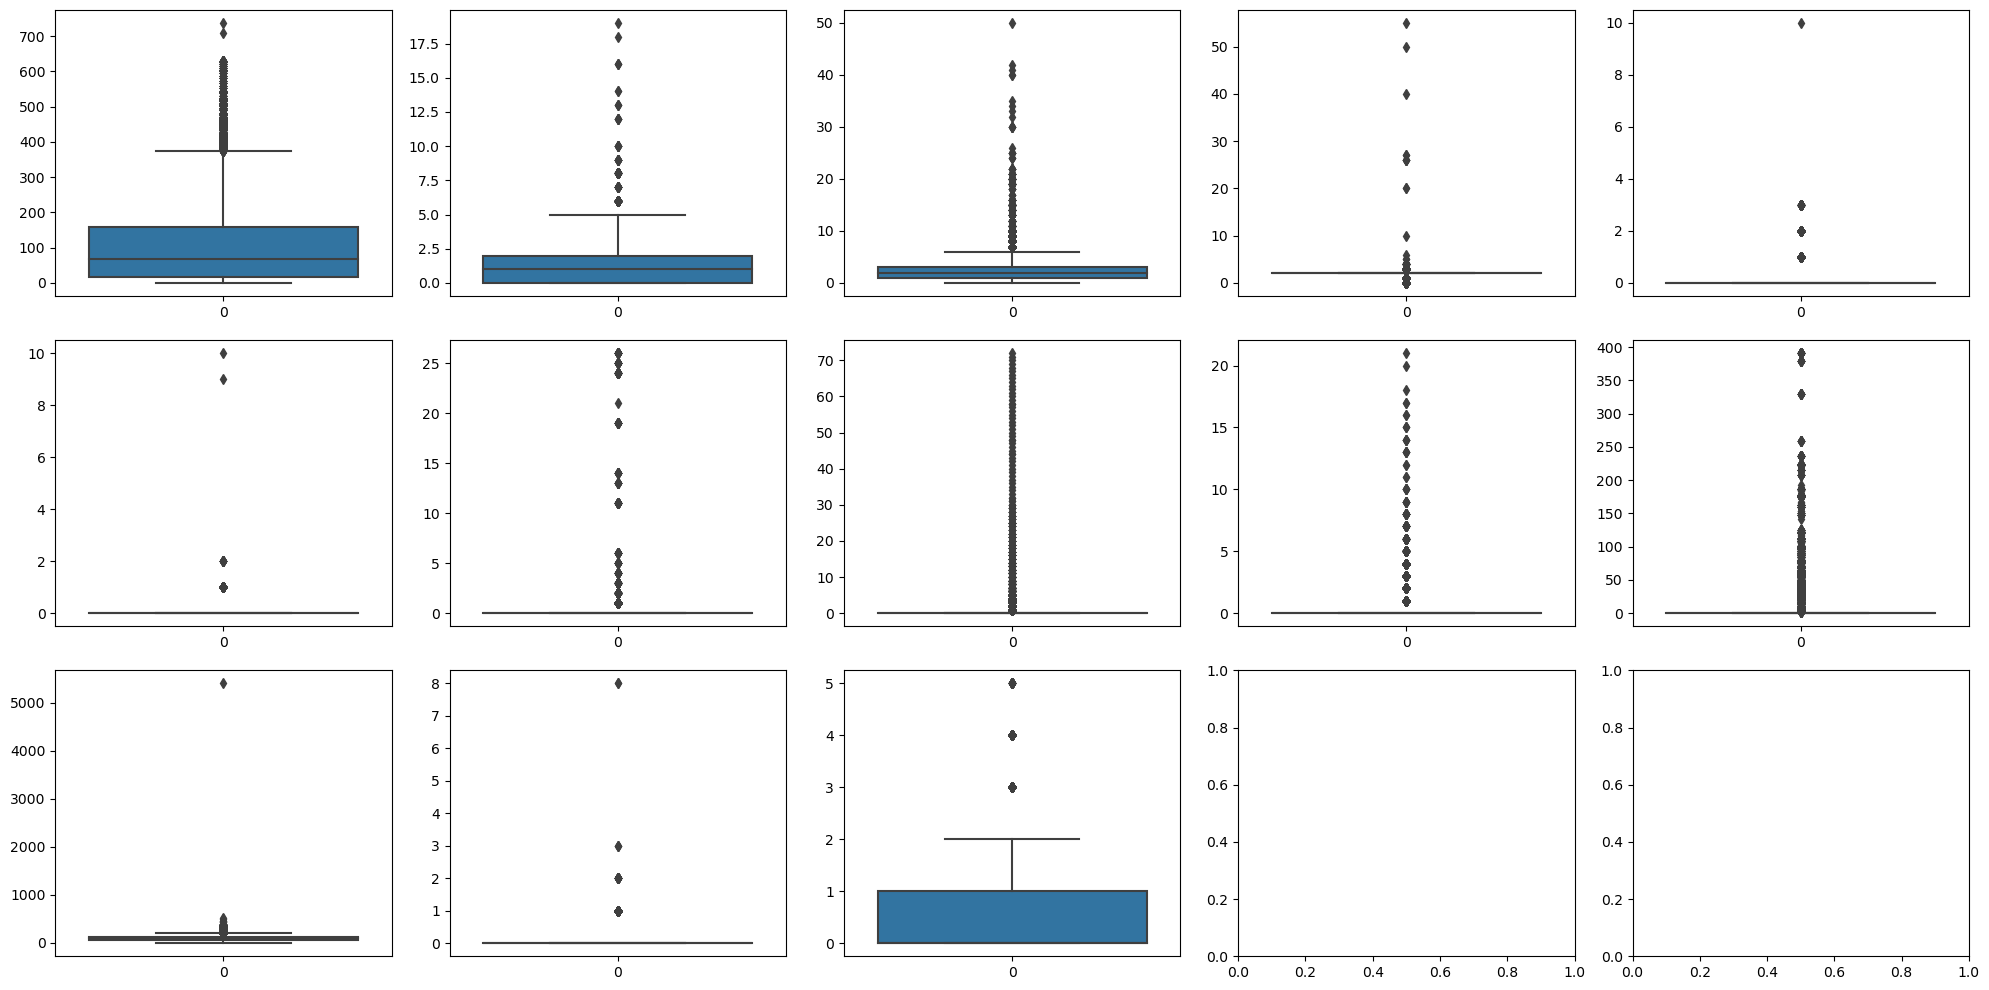

In [94]:
fig, ax= plt.subplots(3,5, figsize=(20,10))

for i, subplot in zip(numerical.columns, ax.flatten()):
    sns.boxplot(df[i], ax=subplot)
    
plt.tight_layout()
plt.show()

## There are presence of outliers
The data exhibits a slight right-skew, as evident from the distribution plots. Notably, the presence of numerous data points exceeding the upper whisker boundary strongly suggests the existence of outliers within the dataset.

# Feature Engineering

Babies and children are combined for a more meaningful data

In [95]:
df['kids'] = df['children'] + df['babies'] # combining kids and babies

In [96]:
df['kids'].value_counts()

0.0     110058
1.0       5446
2.0       3772
3.0        111
10.0         2
9.0          1
Name: kids, dtype: int64

In [97]:
df = df.drop(['children','babies'],axis=1)

In [98]:
df['total_members'] = df['kids'] + df['adults']

In [99]:
def categorize_family(value):
    if value < 3:
        return 'small family'
    elif 3 <= value <= 5:
        return 'medium family'
    else:
        return 'large family'

In [100]:
df['family_size'] = df['total_members'].apply(categorize_family)

In [101]:
df = df.drop(['kids'],axis=1)

Combining the kids and adults to get the family size and coverting them to object data type based on the family size
for better understanding

<Axes: >

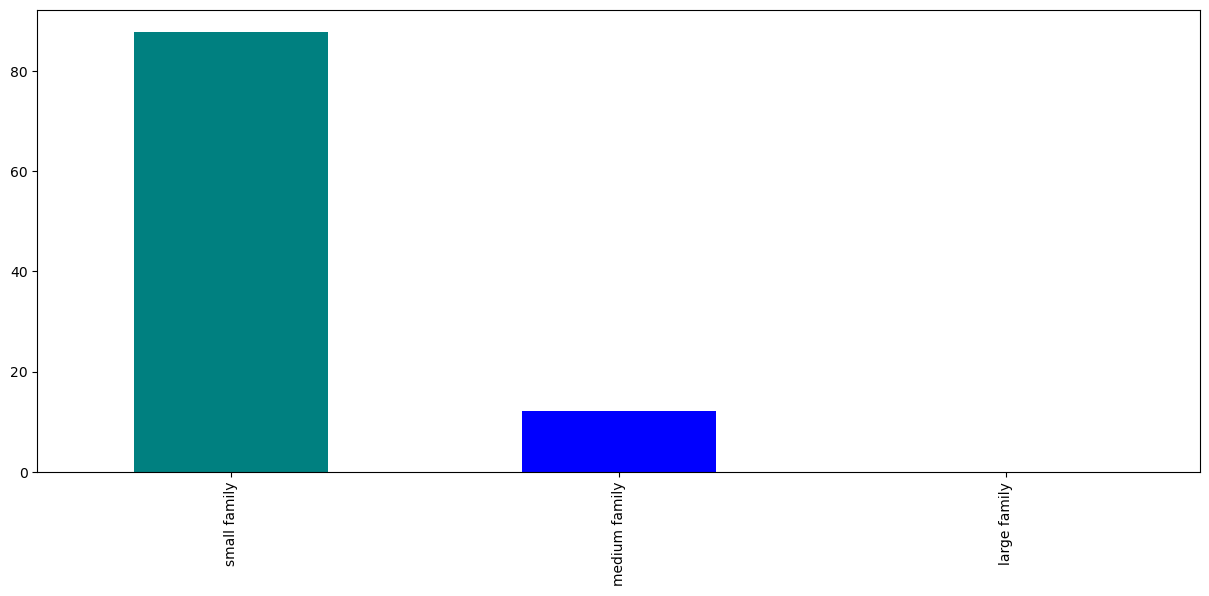

In [102]:
(df['family_size'].value_counts(normalize=True)*100).plot(kind='bar',color = ['teal','blue','yellow'])

grouping the number of people who have booked

In [103]:
def adults_group_booking(num):
    if num == 0:
        return 'Non Adult Bookings'
    elif num == 1:
        return 'Single Adult Bookings'
    elif num == 2:
        return 'Two Adults Bookings'
    elif num == 3:
        return 'Three Adults Bookings'
    else:
        return 'Adults in Group Bookings'
df['adults'] = df['adults'].apply(adults_group_booking)

In [104]:
df = df.drop('total_members',axis=1)

Changing the months according to seasons

In [105]:
df['arrival_date_month'].value_counts()

August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

In [106]:
def season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'
    else:
        return 'Unknown'

In [107]:
df['season'] = df['arrival_date_month'].apply(season)

<Axes: xlabel='season', ylabel='count'>

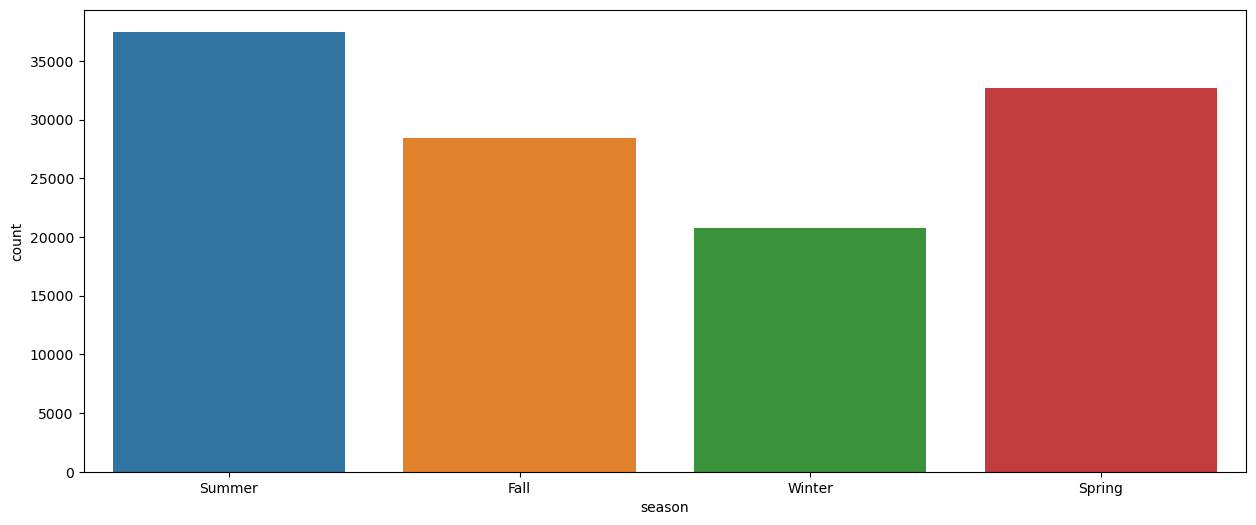

In [108]:
sns.countplot(x=df['season'])

Dropping the columns arrival date year, arrival date month, arrival date day of month as
they are redundant with the column reservation status date

In [109]:
df = df.drop(['arrival_date_year','arrival_date_month',
              'arrival_date_week_number','arrival_date_day_of_month'],axis=1)

If the room type is assigned as same as the reserved its denoted as same else different

In [110]:
df['room_type'] = np.where(df['reserved_room_type'] == df['assigned_room_type'], 'reserved and assigned are same', 'reserved and assigned are different')

In [111]:
df = df.drop(['reserved_room_type','assigned_room_type'],axis=1)

<Axes: >

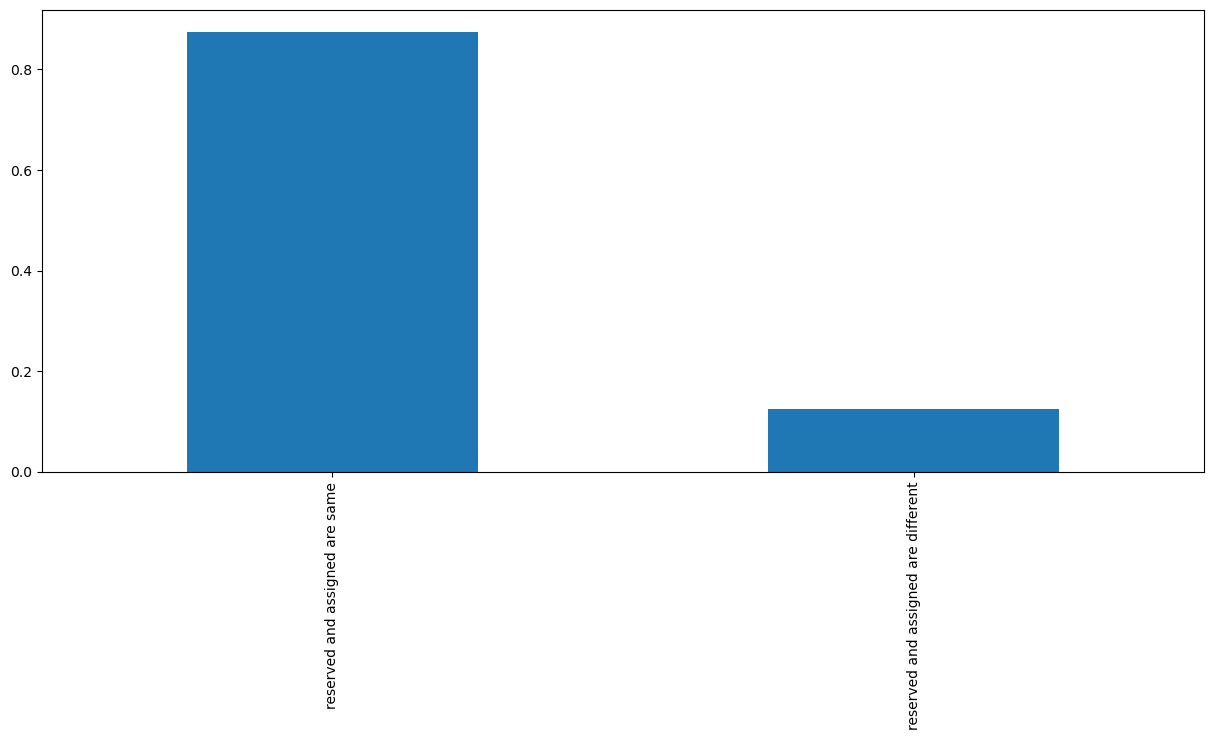

In [112]:
(df['room_type'].value_counts(normalize=True)).plot(kind='bar')

grouping the rows where the frequency is very less

In [113]:
df['market_segment'].value_counts()

Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64

In [114]:
df['market_segment'] = df['market_segment'].replace({'Complementary':'other','Aviation':'other','Undefined':'other'})

In [115]:
df['distribution_channel'].value_counts()

TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: distribution_channel, dtype: int64

In [116]:
df['distribution_channel'] = df['distribution_channel'].replace({'GDS':'other','Undefined':'other'})

In [117]:
df['meal'].value_counts()

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

In [118]:
df['meal'] = df['meal'].replace({'FB':'other','Undefined':'other'})

Seperating the holidays and non holidays

In [119]:
df['Holidays'] = "Non Holiday"
df.loc[df['reservation_status_date'].str.contains('-07-04'), 'Holidays'] = "4th of July"
df.loc[df['reservation_status_date'].str.contains('-01-01'), 'Holidays'] = "New Year's Day"
df.loc[df['reservation_status_date'].str.contains('-12-25'), 'Holidays'] = "Christmas Day"
df.loc[df['reservation_status_date'].str.contains('-11-04'), 'Holidays'] = "Thanksgiving Day"
df.loc[df['reservation_status_date'].str.contains('-04-01'), 'Holidays'] = "Easter"
df.loc[df['reservation_status_date'].str.contains('-07-14'), 'Holidays'] = "Bastille Day"
df.loc[df['reservation_status_date'].str.contains('-10-31'), 'Holidays'] = "Halloween"
df.loc[df['reservation_status_date'].str.contains('-02-14'), 'Holidays'] = "Valentine's Day"
df.loc[df['reservation_status_date'].str.contains('-06-24'), 'Holidays'] = "St. John's Day"
df.loc[df['reservation_status_date'].str.contains('-05-01'), 'Holidays'] = "Labor Day"
df.loc[df['reservation_status_date'].str.contains('-10-03'), 'Holidays'] = "German Unity Day"
df.loc[df['reservation_status_date'].str.contains('-06-06'), 'Holidays'] = "Swedish National Day"
df.loc[df['reservation_status_date'].str.contains('-08-15'), 'Holidays'] = "Assumption of Mary"
df.loc[df['reservation_status_date'].str.contains('-11-01'), 'Holidays'] = "All Saints' Day"
df.loc[df['reservation_status_date'].str.contains('-03-08'), 'Holidays'] = "International Women's Day"
df.loc[df['reservation_status_date'].str.contains('-05-09'), 'Holidays'] = "Europe Day"

In [120]:
df['Holidays'].value_counts(normalize=True)*100

Non Holiday                  95.535640
New Year's Day                0.846805
Valentine's Day               0.316609
Assumption of Mary            0.300695
4th of July                   0.290644
Swedish National Day          0.267192
Bastille Day                  0.265516
Europe Day                    0.264679
Halloween                     0.252115
Labor Day                     0.248765
St. John's Day                0.247089
International Women's Day     0.238713
All Saints' Day               0.229500
Easter                        0.217774
Thanksgiving Day              0.201859
German Unity Day              0.198509
Christmas Day                 0.077896
Name: Holidays, dtype: float64

Grouping the countries with their continents

In [121]:
africa = ['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM', 'COG', 'COD', 'CIV', 'DJI', 'EGY', 'GNQ', 'ERI', 'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 'TUN', 'UGA', 'ZMB', 'ZWE']
asia = ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'BRN', 'KHM', 'CHN', 'CYP', 'GEO', 'IND', 'IDN', 'IRN', 'IRQ', 'ISR', 'JPN', 'JOR', 'KAZ', 'KWT', 'KGZ', 'LAO', 'LBN', 'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'PRK', 'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU', 'SGP', 'KOR', 'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TLS', 'TUR', 'TKM', 'ARE', 'UZB', 'VNM', 'YEM']
north_america = ['CAN', 'USA', 'MEX']
central_america_caribbean = ['ATG', 'BHS', 'BRB', 'BLZ', 'CRI', 'CUB', 'DMA', 'DOM', 'SLV', 'GRD', 'GTM', 'HTI', 'HND', 'JAM', 'NIC', 'PAN', 'KNA', 'LCA', 'VCT', 'TTO']
south_america = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']
oceania = ['AUS', 'FJI', 'KIR', 'MHL', 'FSM', 'NRU', 'NZL', 'PLW', 'PNG', 'WSM', 'SLB', 'TON', 'TUV', 'VUT']
northern_europe = ['DNK', 'EST', 'FIN', 'ISL', 'IRL', 'LVA', 'LTU', 'NOR', 'SWE']
southern_europe = ['ALB', 'AND', 'HRV', 'CYP', 'GRC', 'ITA', 'XKX', 'MLT', 'MNE', 'PRT', 'SMR', 'SRB', 'SVN', 'ESP', 'VAT']
eastern_europe = ['BLR', 'BIH', 'BGR', 'CZE', 'HUN', 'MKD', 'MDA', 'POL', 'ROU', 'RUS', 'SVK', 'UKR']
western_europe = ['AUT', 'BEL', 'FRA', 'DEU', 'LIE', 'LUX', 'MCO', 'NLD', 'CHE', 'GBR']

In [122]:
def countries(i):
        if i in africa:
            return 'Africa'
        elif i in asia:
            return 'Asia'
        elif i in northern_europe:
            return 'Northern European Country'
        elif i in southern_europe:
            return 'Southern European Country'
        elif i in eastern_europe:
            return 'Easthern European Country'
        elif i in western_europe:
            return 'Westhern European Country'
        elif i in north_america:
            return 'North America'
        elif i in central_america_caribbean:
            return 'Central America and Caribbean'
        elif i in south_america:
            return 'South America'
        elif i in oceania:
            return 'Oceania'
        else:
            return 'Other Regions'

In [123]:
df['region']=df['country'].apply(countries)

In [124]:
df['region'].value_counts(normalize=True)*100

Southern European Country        51.797470
Westhern European Country        31.463272
Northern European Country         5.162911
Asia                              2.633386
Easthern European Country         2.269034
South America                     2.268197
North America                     1.827624
Other Regions                     1.165089
Africa                            0.930564
Oceania                           0.421308
Central America and Caribbean     0.061144
Name: region, dtype: float64

<Axes: >

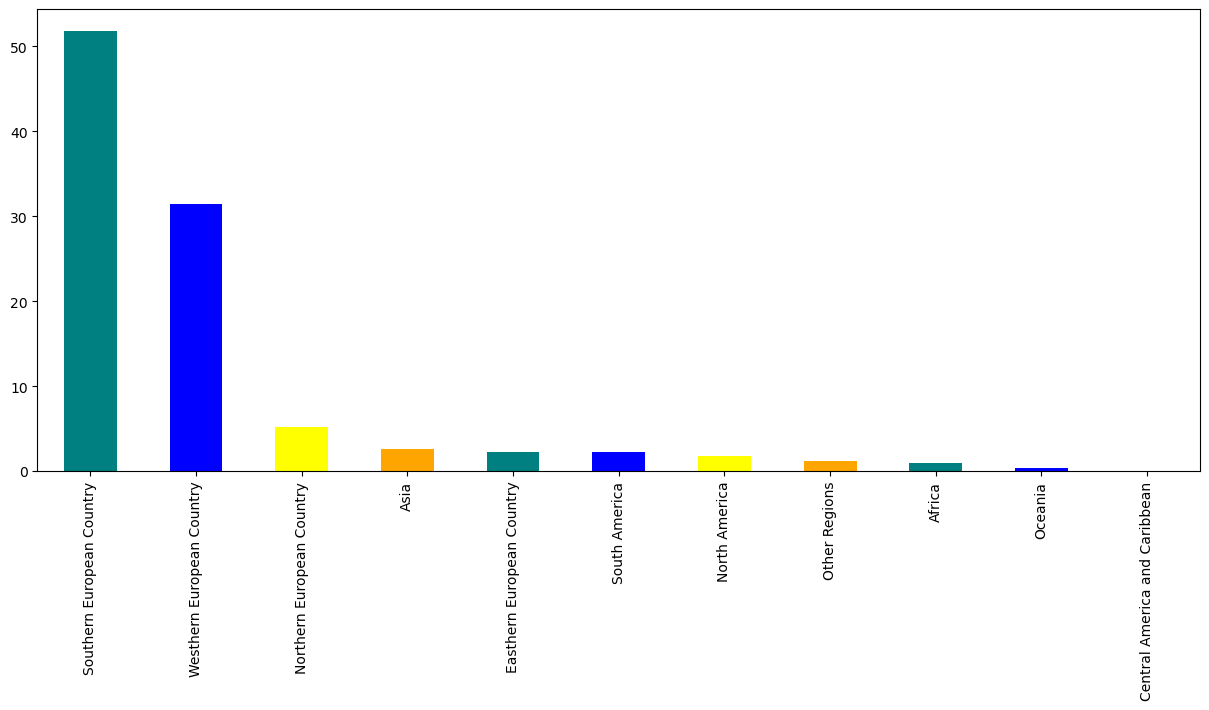

In [125]:
(df['region'].value_counts(normalize=True)*100).plot(kind='bar',color = ['teal','blue','yellow','orange'])

In [126]:
df = df.drop('country',axis=1)

Grouping the agents based on the number of bookings they have done

In [127]:
dict1 = (df.groupby('agent')['is_canceled'].count()).to_dict()

In [128]:
df['agent'] = df['agent'].map(dict1)

In [129]:
df = df.drop('reservation_status_date',axis=1)

In [130]:
df

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family_size,season,room_type,Holidays,region
0,Resort Hotel,0,342,0,0,Two Adults Bookings,BB,Direct,Direct,0,0,0,3,No Deposit,48301,0,Transient,0.00,0,0,small family,Summer,reserved and assigned are same,Non Holiday,Southern European Country
1,Resort Hotel,0,737,0,0,Two Adults Bookings,BB,Direct,Direct,0,0,0,4,No Deposit,48301,0,Transient,0.00,0,0,small family,Summer,reserved and assigned are same,Non Holiday,Southern European Country
2,Resort Hotel,0,7,0,1,Single Adult Bookings,BB,Direct,Direct,0,0,0,0,No Deposit,48301,0,Transient,75.00,0,0,small family,Summer,reserved and assigned are different,Non Holiday,Westhern European Country
3,Resort Hotel,0,13,0,1,Single Adult Bookings,BB,Corporate,Corporate,0,0,0,0,No Deposit,1,0,Transient,75.00,0,0,small family,Summer,reserved and assigned are same,Non Holiday,Westhern European Country
4,Resort Hotel,0,14,0,2,Two Adults Bookings,BB,Online TA,TA/TO,0,0,0,0,No Deposit,13922,0,Transient,98.00,0,1,small family,Summer,reserved and assigned are same,Non Holiday,Westhern European Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2,5,Two Adults Bookings,BB,Offline TA/TO,TA/TO,0,0,0,0,No Deposit,33,0,Transient,96.14,0,0,small family,Summer,reserved and assigned are same,Non Holiday,Westhern European Country
119386,City Hotel,0,102,2,5,Three Adults Bookings,BB,Online TA,TA/TO,0,0,0,0,No Deposit,48301,0,Transient,225.43,0,2,medium family,Summer,reserved and assigned are same,Non Holiday,Westhern European Country
119387,City Hotel,0,34,2,5,Two Adults Bookings,BB,Online TA,TA/TO,0,0,0,0,No Deposit,48301,0,Transient,157.71,0,4,small family,Summer,reserved and assigned are same,Non Holiday,Westhern European Country
119388,City Hotel,0,109,2,5,Two Adults Bookings,BB,Online TA,TA/TO,0,0,0,0,No Deposit,99,0,Transient,104.40,0,0,small family,Summer,reserved and assigned are same,Non Holiday,Westhern European Country


In [131]:
list1 = ['hotel','meal','market_segment','distribution_channel','deposit_type','customer_type','family_size','season','room_type','region','Holidays','required_car_parking_spaces','adults']

In [132]:
for i in list1:
    dummies = pd.get_dummies(df[i], prefix=i, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop(i, axis=1, inplace=True)

In [133]:
df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

# Power transform using Yeo Johnson method to reduce the skewness

In [134]:
columns_to_transform = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','agent','booking_changes',
                      'days_in_waiting_list','adr','total_of_special_requests']

In [135]:
pt = PowerTransformer()

In [136]:
for i in columns_to_transform:
    df[i] = pt.fit_transform(df[[i]])

# Checking the distribution after transforming the data

In [137]:
numericals = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','agent',
              'booking_changes','days_in_waiting_list','adr','total_of_special_requests']

fig, ax= plt.subplots(4,2, figsize=(20,10))

for i, subplot in zip(numericals, ax.flatten()):
    sns.distplot(df[i], ax=subplot,kde=True)
    
plt.tight_layout()
plt.show()

# Splitting the target and independant variables

In [138]:
x = df.drop('is_canceled',axis=1)
y = df['is_canceled']

In [139]:
y = y.astype(int)

In [140]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.80,random_state=5)

In [141]:
xtrain.shape,ytrain.shape

((95512, 68), (95512,))

In [142]:
xtest.shape,ytest.shape

((23878, 68), (23878,))

In [143]:
xtrain

,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,total_of_special_requests,hotel_Resort Hotel,meal_HB,meal_SC,meal_other,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_other,distribution_channel_Direct,distribution_channel_TA/TO,distribution_channel_other,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,family_size_medium family,family_size_small family,season_Spring,season_Summer,season_Winter,room_type_reserved and assigned are same,region_Asia,region_Central America and Caribbean,region_Easthern European Country,region_North America,region_Northern European Country,region_Oceania,region_Other Regions,region_South America,region_Southern European Country,region_Westhern European Country,Holidays_All Saints' Day,Holidays_Assumption of Mary,Holidays_Bastille Day,Holidays_Christmas Day,Holidays_Easter,Holidays_Europe Day,Holidays_German Unity Day,Holidays_Halloween,Holidays_International Women's Day,Holidays_Labor Day,Holidays_New Year's Day,Holidays_Non Holiday,Holidays_St. John's Day,Holidays_Swedish National Day,Holidays_Thanksgiving Day,Holidays_Valentine's Day,required_car_parking_spaces_1,required_car_parking_spaces_2,required_car_parking_spaces_3,required_car_parking_spaces_8,adults_Non Adult Bookings,adults_Single Adult Bookings,adults_Three Adults Bookings,adults_Two Adults Bookings
22417,-1.034109,0.391880,0.502708,0,0,0,2.377102,0.200743,-0.178785,-1.041879,1.027465,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
117285,-1.289949,0.391880,-0.875286,0,0,0,-0.422391,1.061204,-0.178785,-0.718988,1.027465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
109605,0.907131,1.125252,0.502708,0,0,0,-0.422391,1.061204,-0.178785,1.657895,-0.826186,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
94421,0.996958,1.125252,-0.077102,0,0,0,-0.422391,-0.509355,-0.178785,-0.788118,1.027465,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
114575,0.471051,1.125252,0.960315,0,0,0,-0.422391,1.061204,-0.178785,0.569698,-0.826186,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520,0.851416,1.125252,1.339394,0,0,0,-0.422391,-0.985814,-0.178785,-0.758064,1.027465,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
101350,-0.589166,0.391880,0.502708,0,0,0,-0.422391,-1.322094,-0.178785,0.937966,-0.826186,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
20463,0.416188,1.125252,1.339394,0,0,0,-0.422391,0.200743,-0.178785,-1.341640,1.027465,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
18638,-1.838239,0.391880,-0.875286,1,0,1,2.363300,1.061204,-0.178785,-1.441636,-0.826186,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


# User defined function to store our results

In [144]:
perf_score = pd.DataFrame(columns=["Model", "Accuracy","Recall","Precision","F1 Score"] )

In [145]:
def per_measures(model,test,pred):
    accuracy    =accuracy_score(test,pred)
    f1score     =f1_score(test,pred)
    recall      =recall_score(test,pred)
    precision   =precision_score(test,pred)
      # aic         =model.aic
      # reliability = cohen_kappa_score(test,pred)
    return (accuracy,recall,precision,f1score)

In [146]:
def update_performance (name,
                        model,
                        test,
                        pred
                           ):

    # assign 'comp_perf' as global variable
    global perf_score


    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    perf_score = perf_score.append({'Model'       : name,
                                    'Accuracy'    : per_measures(model,test,pred)[0],
                                    'Recall'      : per_measures(model,test,pred)[1],
                                    'Precision'   : per_measures(model,test,pred)[2],
                                    'F1 Score'    : per_measures(model,test,pred)[3]
                                    # 'AIC'         : per_measures(model,ytest,ypred)[4],
                                    # 'Reliability' : per_measures(model,ytest,ypred)[5]

                                     },
                                   ignore_index = True)

# Base model

In [147]:
lr = LogisticRegression()
model = lr.fit(xtrain,ytrain)

In [148]:
ypred = model.predict(xtest)
ypred_train = model.predict(xtrain)

In [149]:
# for training data
accuracy_score(ytrain,ypred_train)

0.8301469972359494

In [150]:
# for testing data
accuracy_score(ytest,ypred)

0.8277912723008627

In [151]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87     15033
           1       0.82      0.69      0.75      8845

    accuracy                           0.83     23878
   macro avg       0.82      0.80      0.81     23878
weighted avg       0.83      0.83      0.82     23878



In [152]:
update_performance(name='Base model',model=lr,test=ytest,pred=ypred)

In [153]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563


# Feature Selection

In [154]:
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [155]:
importance = pd.DataFrame({'Features':xtrain.columns,
              'Importance': dt.feature_importances_})
importance = importance.sort_values('Importance',ascending= False,ignore_index=True)
importance

,Features,Importance
0,deposit_type_Non Refund,0.236192
1,lead_time,0.154764
2,adr,0.115011
3,region_Southern European Country,0.066839
4,agent,0.059432
...,...,...
63,Holidays_Christmas Day,0.000101
64,deposit_type_Refundable,0.000038
65,required_car_parking_spaces_2,0.000000
66,required_car_parking_spaces_3,0.000000


In [156]:
impt_thresh = importance[importance['Importance']>0.002]

In [157]:
impt_thresh

,Features,Importance
0,deposit_type_Non Refund,0.236192
1,lead_time,0.154764
2,adr,0.115011
3,region_Southern European Country,0.066839
4,agent,0.059432
5,total_of_special_requests,0.042312
6,stays_in_week_nights,0.042205
7,room_type_reserved and assigned are same,0.034462
8,previous_cancellations,0.030894
9,stays_in_weekend_nights,0.025171


In [158]:
xtrain = xtrain[impt_thresh['Features']]
xtest = xtest[impt_thresh['Features']]

# Knn model

## Grid search cv to find the best parameters

In [159]:
parameters = {'n_neighbors':[3,5,7],'p':[1,2]}
knn=KNeighborsClassifier()
knncv=GridSearchCV(estimator=knn,param_grid=parameters,cv=5,scoring="accuracy")
knncv.fit(xtrain,ytrain)
knncv.best_params_

{'n_neighbors': 7, 'p': 1}

## Building the model using the best parameters

In [160]:
knn=KNeighborsClassifier(n_neighbors=7,p=1)
knn.fit(xtrain,ytrain)
ypred = knn.predict(xtest)

In [161]:
update_performance(name='Knn model with Feature Selection',model=knn,test=ytest,pred=ypred)

In [162]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675


# Decision tree model

## To find the best Parameters

In [163]:
parameters = {'max_depth':[3,5,7],'criterion':['entropy','gini']}
dt = DecisionTreeClassifier()
dtcv = GridSearchCV(dt,param_grid=parameters,scoring='accuracy')
dtcv.fit(xtrain,ytrain)
dtcv.best_params_

{'criterion': 'gini', 'max_depth': 7}

## Using the best parameters

In [164]:
dt = DecisionTreeClassifier(max_depth=7,criterion='gini')
dt.fit(xtrain,ytrain)
ypred = dt.predict(xtest)

In [165]:
update_performance(name='Decision tree model with Feature Selection',model=dt,test=ytest,pred=ypred)

In [166]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181


## We can see that the Knn model gives a better output compared to decision tree

# Random forest classifier

## Finding out the best parameters

In [167]:
params =             [{'criterion': ['entropy', 'gini'],
                     'n_estimators': [100],
                     'max_depth': [10, 15],
                     'max_features': ['sqrt', 'log2'],
                     'min_samples_split': [2, 8],
                     'min_samples_leaf': [5, 9],
                     'max_leaf_nodes': [8, 11]}]

## The best parameters

In [168]:
rf = RandomForestClassifier()
rfcv = GridSearchCV(rf,params,cv=5,scoring='accuracy')
rfcv.fit(xtrain,ytrain)
rfcv.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': 11,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [169]:
rf=RandomForestClassifier(criterion='gini',
 max_depth= 15,
 max_features= 'sqrt',
 max_leaf_nodes= 11,
 min_samples_leaf= 5,
 min_samples_split= 8,
 n_estimators=100)
rf.fit(xtrain,ytrain)
ypred = rf.predict(xtest)

In [170]:
update_performance(name='Random Forest model with Feature Selection',model=rf,test=ytest,pred=ypred)

In [171]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198


## Bagging classifier using Knn model

In [172]:
knn = KNeighborsClassifier()
bc_knn = BaggingClassifier(knn)
bc_knn.fit(xtrain,ytrain)
ypred = bc_knn.predict(xtest)

In [173]:
update_performance(name='Bagging using Knn with Feature Selection',model=bc_knn,test=ytest,pred=ypred)

In [174]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198
4,Bagging using Knn with Feature Selection,0.848270,0.772075,0.809507,0.790348


## Bagging classifier using decision tree model

In [175]:
dt = DecisionTreeClassifier()
bc_dt = BaggingClassifier(dt)
bc_dt.fit(xtrain,ytrain)
ypred = bc_dt.predict(xtest)

In [176]:
update_performance(name='Bagging using dt with Feature Selection',model=bc_dt,test=ytest,pred=ypred)

In [177]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198
4,Bagging using Knn with Feature Selection,0.848270,0.772075,0.809507,0.790348
5,Bagging using dt with Feature Selection,0.873984,0.786546,0.861228,0.822195


# Using stacking classifier for Logistic regression,K nearest neighbors and decision tree

In [178]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
stack = StackingClassifier(estimators=[('lr_model',lr),('knn_model',knn),('DT_model',dt)])
stack.fit(xtrain,ytrain)
ypred = stack.predict(xtest)

In [179]:
update_performance(name='stacking using lr,knn,dt with Feature Selection',model=stack,test=ytest,pred=ypred)

In [180]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198
4,Bagging using Knn with Feature Selection,0.848270,0.772075,0.809507,0.790348
5,Bagging using dt with Feature Selection,0.873984,0.786546,0.861228,0.822195
6,"stacking using lr,knn,dt with Feature Selection",0.871262,0.788355,0.852966,0.819389


# Using different Boosting methods

# Ada boost

## Ada boost using Random Forest

In [181]:
rf = RandomForestClassifier()
adb_rf = AdaBoostClassifier(rf)
adb_rf.fit(xtrain,ytrain)
ypred = adb_rf.predict(xtest)

In [182]:
update_performance(name='Ada boost with random forest and Feature Selection',model=adb_rf,test=ytest,pred=ypred)

In [183]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198
4,Bagging using Knn with Feature Selection,0.848270,0.772075,0.809507,0.790348
5,Bagging using dt with Feature Selection,0.873984,0.786546,0.861228,0.822195
6,"stacking using lr,knn,dt with Feature Selection",0.871262,0.788355,0.852966,0.819389
7,Ada boost with random forest and Feature Selec...,0.878214,0.777954,0.879361,0.825555


# Gradient boost

In [184]:
gbc = GradientBoostingClassifier(n_estimators = 50,learning_rate=0.5,max_depth=5)
gbc.fit(xtrain,ytrain)
ypred = gbc.predict(xtest)

In [185]:
update_performance(name='Gradient boost with Feature Selection',model=gbc,test=ytest,pred=ypred)

In [186]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198
4,Bagging using Knn with Feature Selection,0.848270,0.772075,0.809507,0.790348
5,Bagging using dt with Feature Selection,0.873984,0.786546,0.861228,0.822195
6,"stacking using lr,knn,dt with Feature Selection",0.871262,0.788355,0.852966,0.819389
7,Ada boost with random forest and Feature Selec...,0.878214,0.777954,0.879361,0.825555
8,Gradient boost with Feature Selection,0.862091,0.772301,0.842293,0.805780


# Extreme gradient boosting

In [187]:
xgb = XGBClassifier()
xgb.fit(xtrain,ytrain)
ypred = xgb.predict(xtest)

In [188]:
update_performance(name='Extreme gradient boost with Feature Selection',model=xgb,test=ytest,pred=ypred)

In [189]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score
0,Base model,0.827791,0.692029,0.815155,0.748563
1,Knn model with Feature Selection,0.851369,0.771735,0.816898,0.793675
2,Decision tree model with Feature Selection,0.812254,0.575240,0.875129,0.694181
3,Random Forest model with Feature Selection,0.786079,0.446354,0.949267,0.607198
4,Bagging using Knn with Feature Selection,0.848270,0.772075,0.809507,0.790348
5,Bagging using dt with Feature Selection,0.873984,0.786546,0.861228,0.822195
6,"stacking using lr,knn,dt with Feature Selection",0.871262,0.788355,0.852966,0.819389
7,Ada boost with random forest and Feature Selec...,0.878214,0.777954,0.879361,0.825555
8,Gradient boost with Feature Selection,0.862091,0.772301,0.842293,0.805780
9,Extreme gradient boost with Feature Selection,0.866320,0.781685,0.845749,0.812456


In [190]:
print('The average Accuracy of all the models is :',perf_score['Accuracy'].mean())

The average Accuracy of all the models is : 0.8477636317949576


In [191]:
perf_score[perf_score['Accuracy']==np.max(perf_score['Accuracy'])]

,Model,Accuracy,Recall,Precision,F1 Score
7,Ada boost with random forest and Feature Selec...,0.878214,0.777954,0.879361,0.825555


In [192]:
ypred_train= adb_rf.predict(xtrain)
ypred_test = adb_rf.predict(xtest)

In [193]:
# training data
accuracy_score(ytrain,ypred_train)

0.9942834408241896

In [194]:
# testing data
accuracy_score(ytest,ypred_test)

0.8782142558003183

# From the above model the accuracy of Ada boost with random forest seems to be considerable higher than the other models.

In [195]:
ypred_prob = adb_rf.predict_proba(xtest)

In [196]:
ypred_prob

array([[1.39608923e-01, 8.60391077e-01],
       [9.99999898e-01, 1.01878665e-07],
       [8.30140123e-01, 1.69859877e-01],
       ...,
       [7.64736481e-01, 2.35263519e-01],
       [2.98684166e-01, 7.01315834e-01],
       [1.00000000e+00, 2.22044605e-16]])

roc-score: 0.946720854594736


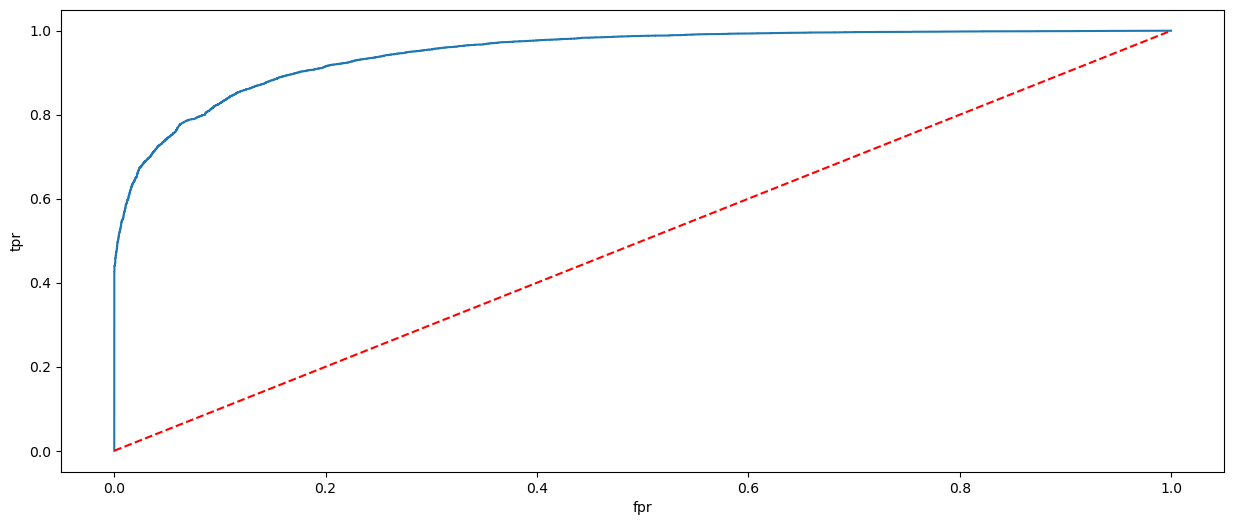

In [197]:
fpr,tpr,threshold = roc_curve(ytest,ypred_prob[:,1])
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0,1],[0,1],'r--')
print('roc-score:',roc_auc_score(ytest,ypred_prob[:,1]))
plt.show()

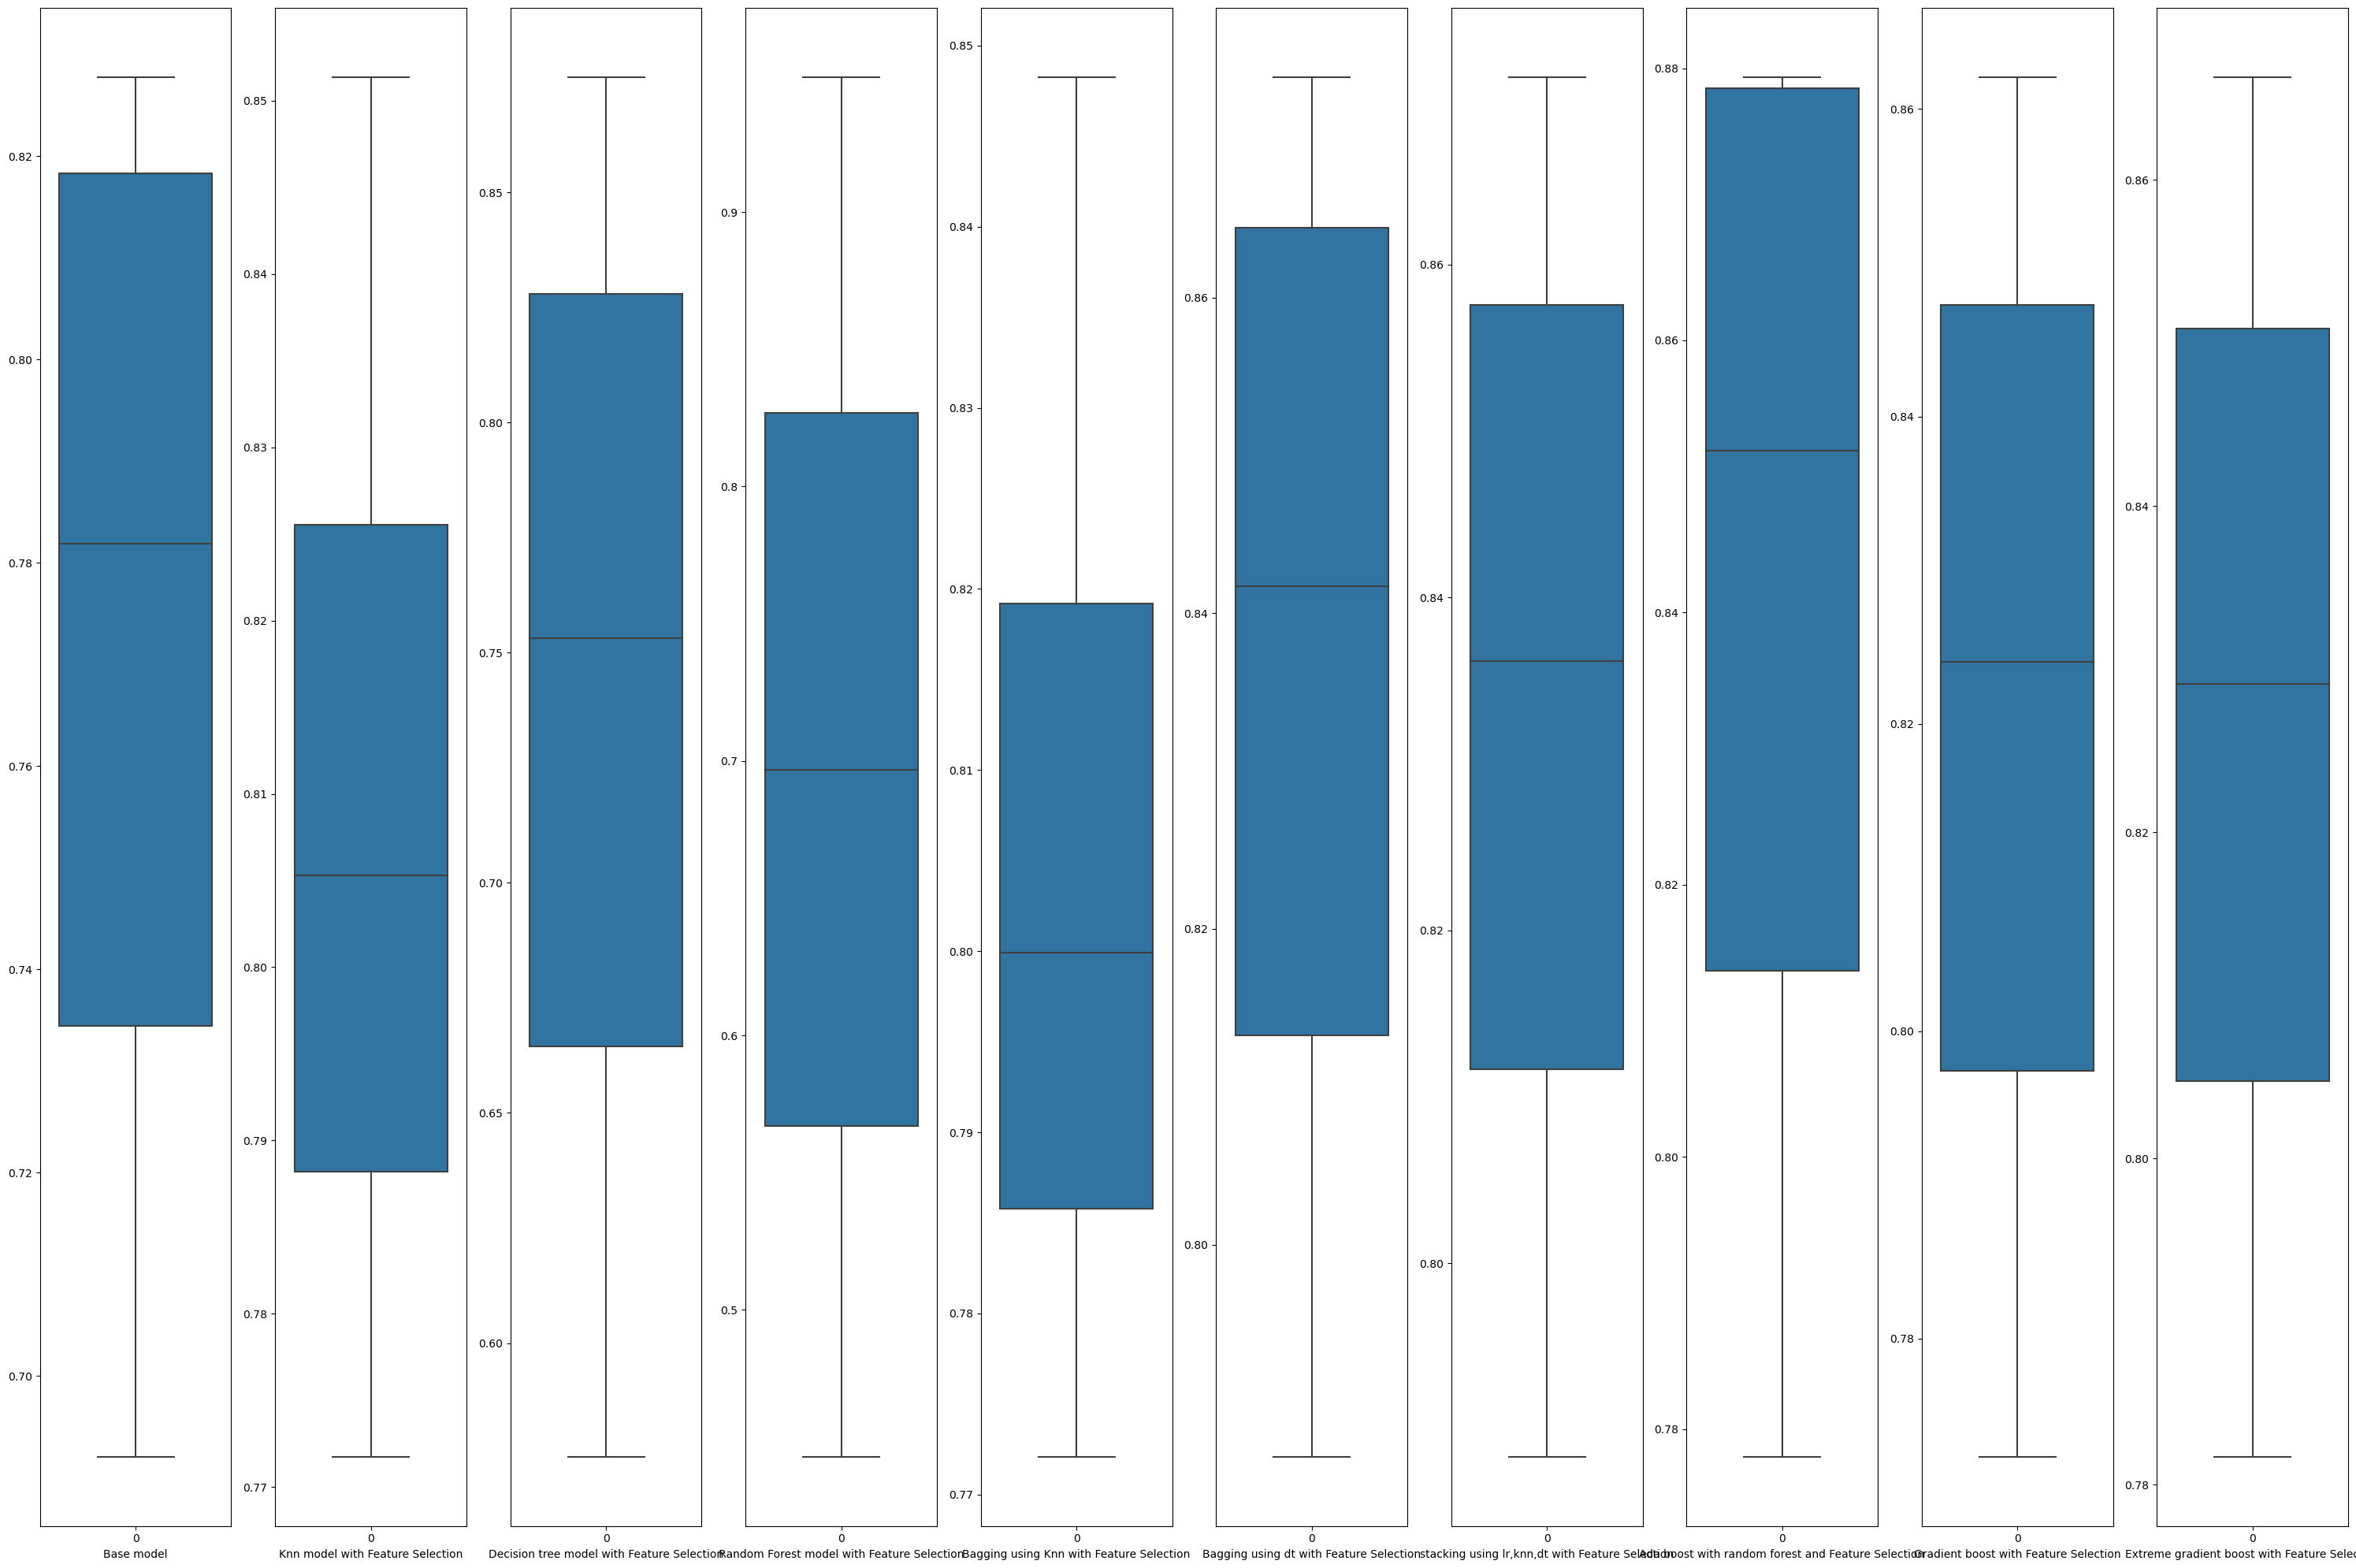

In [198]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(30, 20))
for i in range(10):
    sns.boxplot(perf_score.iloc[i][1:], ax=ax[i])
    ax[i].set_xlabel(perf_score.iloc[i][0])
plt.tight_layout()
plt.show()

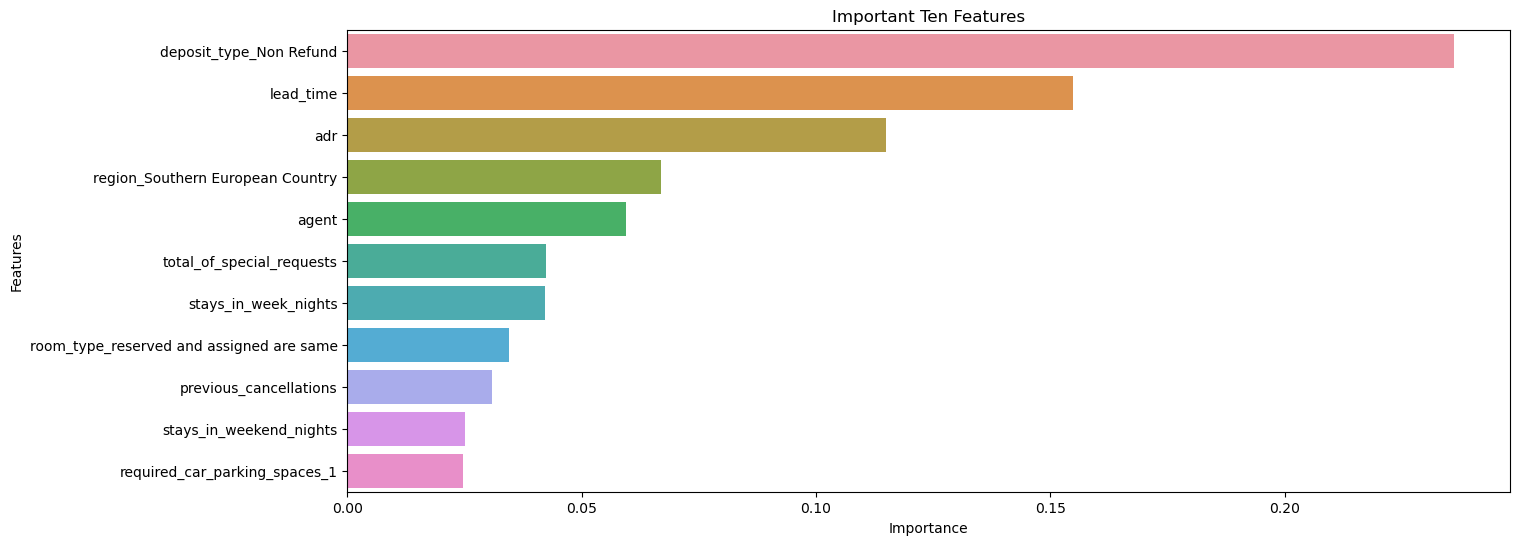

In [199]:
sns.barplot(data=impt_thresh[0:11],y='Features',x='Importance')
plt.title('Important Ten Features')
plt.show()

# Bussiness Understanding and Interpretation

During the time of year when there is a radical number of bookings due to 
holidays and events this model will help us determine if the customer who booked the 
rooms will show up (pay for the rooms after stay) at these peak seasons or the reserved 
rooms would not bring in revenue.

 The model is about analyzing a dataset that contains two distinct hotels namely 
“city hotels” and “resort hotels”, The primary objective is to find whether the person 
who booked hotel rooms, checked in or cancelled the booking. The challenge is 
significant for hotel management as it helps in determining the status during the period 
of booking and helps to manage their resources effectively and enhance their 
operations

*Which variables are significant in predicting the bookings of customer will be cancelled or not? The significant variables are:*
'deposit_type_Non Refund',
'lead_time',
'adr',
'region_Southern European Country',
'agent',
'stays_in_week_nights'
* deposit_type_Non Refund - The Customers with non refundable deposit type.
* lead_time - No. Of days that elapsed between the entering date of the booking and arrival date
* adr - Average daily rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
* region_Southern European Country - Locations of customers from Countries in Southern Europen Region
* agent -  the number of bookings done by an Agent
* stays_in_week_nights - No of weekend nights (saturday or sunday). The guest stayed or booked to stay at the hotel